In [1]:
import argparse
import sys
import os
# Parent folder imports
current_dir = os.path.abspath(os.getcwd())
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from data_loading_sym import PartialMNIST_AE_Dataloader, RotMNIST_AE_Dataloader
from collections import OrderedDict
from modules_sym import PartEqMod
import pytorch_lightning as pl


# Configuration
parser = argparse.ArgumentParser()
parser.add_argument('--seed', type=int, default=0)
parser.add_argument("--dataloader_batch_sz", type=int, default=256)

# Dataset
parser.add_argument("--dataset_root", type=str,
                    default="../datasets")
parser.add_argument("--dataset", type=str,
                    default="PartMNIST")
parser.add_argument("--customdata_train_path", type=str,
                    default="../datasets/mnist60/invariant_dataset_train.pkl")
parser.add_argument("--customdata_test_path", type=str,
                    default="../datasets/mnist60/invariant_dataset_test.pkl")


# Net params
parser.add_argument("--discrete_groups", default=False, type=bool)
parser.add_argument("--in_channels", default=1, type=int)  # Size of the networks in Inv AE
parser.add_argument("--hidden_dim", default=128, type=int)  # Size of the networks in Inv AE
parser.add_argument("--emb_dim", default=32, type=int)  # Dimension of latent spaces
parser.add_argument("--hidden_dim_theta", default=64, type=int)  # Size of theta network
parser.add_argument("--emb_dim_theta", default=100, type=int)  # Size of embedding space in theta network
parser.add_argument("--use_one_layer", action='store_true', default=False)
parser.add_argument("--pretrained_path", type=str, default="./")  # Pretrained Model Path

config, _ = parser.parse_known_args()

# Set seed
if config.seed == -1:
    config.seed = np.random.randint(0, 100000)
pl.seed_everything(config.seed)

c:\users\uualo\documents\vu ai\thesis\code\so2unsupervised\.venv\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
Global seed set to 0


0

In [2]:
# Change accordingly
EXPERIMENT = "ROTMNIST60-90"

In [3]:
if "MNIST" in EXPERIMENT:
        config.in_channels = 1
        config.emb_dim_theta = 128
        config.hidden_dim_theta = 64
        num_classes = 10
        if EXPERIMENT == "ROTMNIST60-90":
            config.customdata_test_path = "../datasets/mnist60_90_test.pkl"
            config.pretrained_path = "../models/ie-ae/mnist6090/best_model_theta.pt"
            # Net
            config.hidden_dim = 64
            config.emb_dim = 200
        if EXPERIMENT == "MNISTMULTIPLE":
            config.customdata_test_path = "../datasets/mnist_multiple_test.pkl"
            config.pretrained_path = "../models/ie-ae/mnistmultiple/best_model_theta.pt"
            # Net
            config.hidden_dim = 64
            config.emb_dim = 200

In [4]:
%%capture
# Load IE-AE pretrained model
net = PartEqMod(hparams=config)
state_dict = torch.load(config.pretrained_path)

new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace("model.", "")  # remove "model."
    new_state_dict[name] = v
keys_to_load = {k: v for k, v in new_state_dict.items()}

print(f"Loading pre-trained model for {EXPERIMENT}.")

net.load_state_dict(keys_to_load, strict=False)
net.cuda()
net.eval()


In [5]:
# Load the data.
if ".pkl" in config.customdata_test_path:
    test_dataloader = PartialMNIST_AE_Dataloader(config, train=False, test=True, shuffle=True,
                                                 no_val_split=True)
    test_dataloader = test_dataloader[0]
if ".amat" in config.customdata_test_path:
    test_dataloader = RotMNIST_AE_Dataloader(config, train=False, test=True, shuffle=True,
                                             no_val_split=True)
    test_dataloader = test_dataloader[0]

Loading for train: False , and for test: True


In [6]:
%%capture
plt.style.use('seaborn-whitegrid')
# Print densities
os.makedirs(f"./plots/{EXPERIMENT}_IE-AE_COMPARISON", exist_ok=True)

thetas_dict = {i: [] for i in range(num_classes)}
labels_dict = {i: [] for i in range(num_classes)}
all_thetas_dict = {i: [] for i in range(num_classes)}

all_transforms = []
all_transforms_dict = {i: [] for i in range(num_classes)}
# Insert true level of rotation of each dataset

net.eval()
for x, label in test_dataloader:
    x = x.cuda()
    label = label.long().cuda()

    with torch.no_grad():
        # Encoder pass
        emb, v = net.encoder(x)
        rot = net.get_rotation_matrix(v)
        degrees_rot = net.get_degrees(rot)

        # Theta function
        #degrees_theta = net.theta_function(x).squeeze()
        all_transforms.extend(degrees_rot.cpu().numpy())

        # Loop through each class and gather rotations
        for lab in range(num_classes):
            mask = (label == lab)

            # Extract values
            #sub_thetas = degrees_theta[mask].cpu().numpy()
            sub_labels = label[mask].cpu().numpy()
            sub_degrees = degrees_rot[mask].cpu().numpy()

            # Save the values
            #mean_degrees = np.nanmean(sub_thetas)  # Beware of nan values when the mask is all False
            #thetas_dict[lab].append(mean_degrees)
            labels_dict[lab].extend(sub_labels.tolist())
            #all_thetas_dict[lab].extend(sub_thetas.tolist())
            all_transforms_dict[lab].extend(sub_degrees.tolist())

# Save Histogram for Psi per label
for lab in range(num_classes):
    fig, ax = plt.subplots(figsize=(12, 8))
    df = pd.DataFrame()
    df["psi"] = all_transforms_dict[lab]
    kde = df["psi"].plot.kde(ax=ax, label="_nolegend_", lw=2)
    # Save the psi values for later visualization purposes
    df.to_csv(f"plots/{EXPERIMENT}_IE-AE_COMPARISON/ieae_rotations_class_" + str(lab) + ".csv", index=False)
    plt.close()

In [7]:
if "MNIST" in EXPERIMENT:
        config.in_channels = 1
        config.emb_dim_theta = 128
        config.hidden_dim_theta = 64
        num_classes = 10
        if EXPERIMENT == "ROTMNIST60-90":
            config.customdata_test_path = "../datasets/mnist60_90_test.pkl"
            config.pretrained_path = "../models/mnist6090/best_model_theta.pt"
            # Net
            config.hidden_dim = 64
            config.emb_dim = 200
        if EXPERIMENT == "MNISTMULTIPLE":
            config.customdata_test_path = "../datasets/mnist_multiple_test.pkl"
            config.pretrained_path = "../models/mnistmultiple/best_model_theta.pt"
            # Net
            config.hidden_dim = 64
            config.emb_dim = 200

In [8]:
%%capture
# Load SSL-SYM model
net = PartEqMod(hparams=config)
state_dict = torch.load(config.pretrained_path)

new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace("model.", "")  # remove "model."
    new_state_dict[name] = v
keys_to_load = {k: v for k, v in new_state_dict.items()}

print(f"Loading pre-trained model for {EXPERIMENT}.")

net.load_state_dict(keys_to_load, strict=False)
net.cuda()
net.eval()

In [9]:
# Load the data.
if ".pkl" in config.customdata_test_path:
    test_dataloader = PartialMNIST_AE_Dataloader(config, train=False, test=True, shuffle=True,
                                                 no_val_split=True)
    test_dataloader = test_dataloader[0]
if ".amat" in config.customdata_test_path:
    test_dataloader = RotMNIST_AE_Dataloader(config, train=False, test=True, shuffle=True,
                                             no_val_split=True)
    test_dataloader = test_dataloader[0]

Loading for train: False , and for test: True


In [10]:
%%capture
plt.style.use('seaborn-whitegrid')
# Print densities
os.makedirs(f"./plots/{EXPERIMENT}_IE-AE_COMPARISON", exist_ok=True)

thetas_dict = {i: [] for i in range(num_classes)}
labels_dict = {i: [] for i in range(num_classes)}
all_thetas_dict = {i: [] for i in range(num_classes)}

all_transforms = []
all_transforms_dict = {i: [] for i in range(num_classes)}
# Insert true level of rotation of each dataset

net.eval()
for x, label in test_dataloader:
    x = x.cuda()
    label = label.long().cuda()

    with torch.no_grad():
        # Encoder pass
        emb, v = net.encoder(x)
        rot = net.get_rotation_matrix(v)
        degrees_rot = net.get_degrees(rot)

        # Theta function
        #degrees_theta = net.theta_function(x).squeeze()
        all_transforms.extend(degrees_rot.cpu().numpy())

        # Loop through each class and gather rotations
        for lab in range(num_classes):
            mask = (label == lab)

            # Extract values
            #sub_thetas = degrees_theta[mask].cpu().numpy()
            sub_labels = label[mask].cpu().numpy()
            sub_degrees = degrees_rot[mask].cpu().numpy()

            # Save the values
            #mean_degrees = np.nanmean(sub_thetas)  # Beware of nan values when the mask is all False
            #thetas_dict[lab].append(mean_degrees)
            labels_dict[lab].extend(sub_labels.tolist())
            #all_thetas_dict[lab].extend(sub_thetas.tolist())
            all_transforms_dict[lab].extend(sub_degrees.tolist())

# Save Histogram for Psi per label
for lab in range(num_classes):
    fig, ax = plt.subplots(figsize=(12, 8))
    df = pd.DataFrame()
    df["psi"] = all_transforms_dict[lab]
    kde = df["psi"].plot.kde(ax=ax, label="_nolegend_", lw=2)
    # Save the psi values for later visualization purposes
    df.to_csv(f"plots/{EXPERIMENT}_IE-AE_COMPARISON/rotations_class_" + str(lab) + ".csv", index=False)
    plt.close()

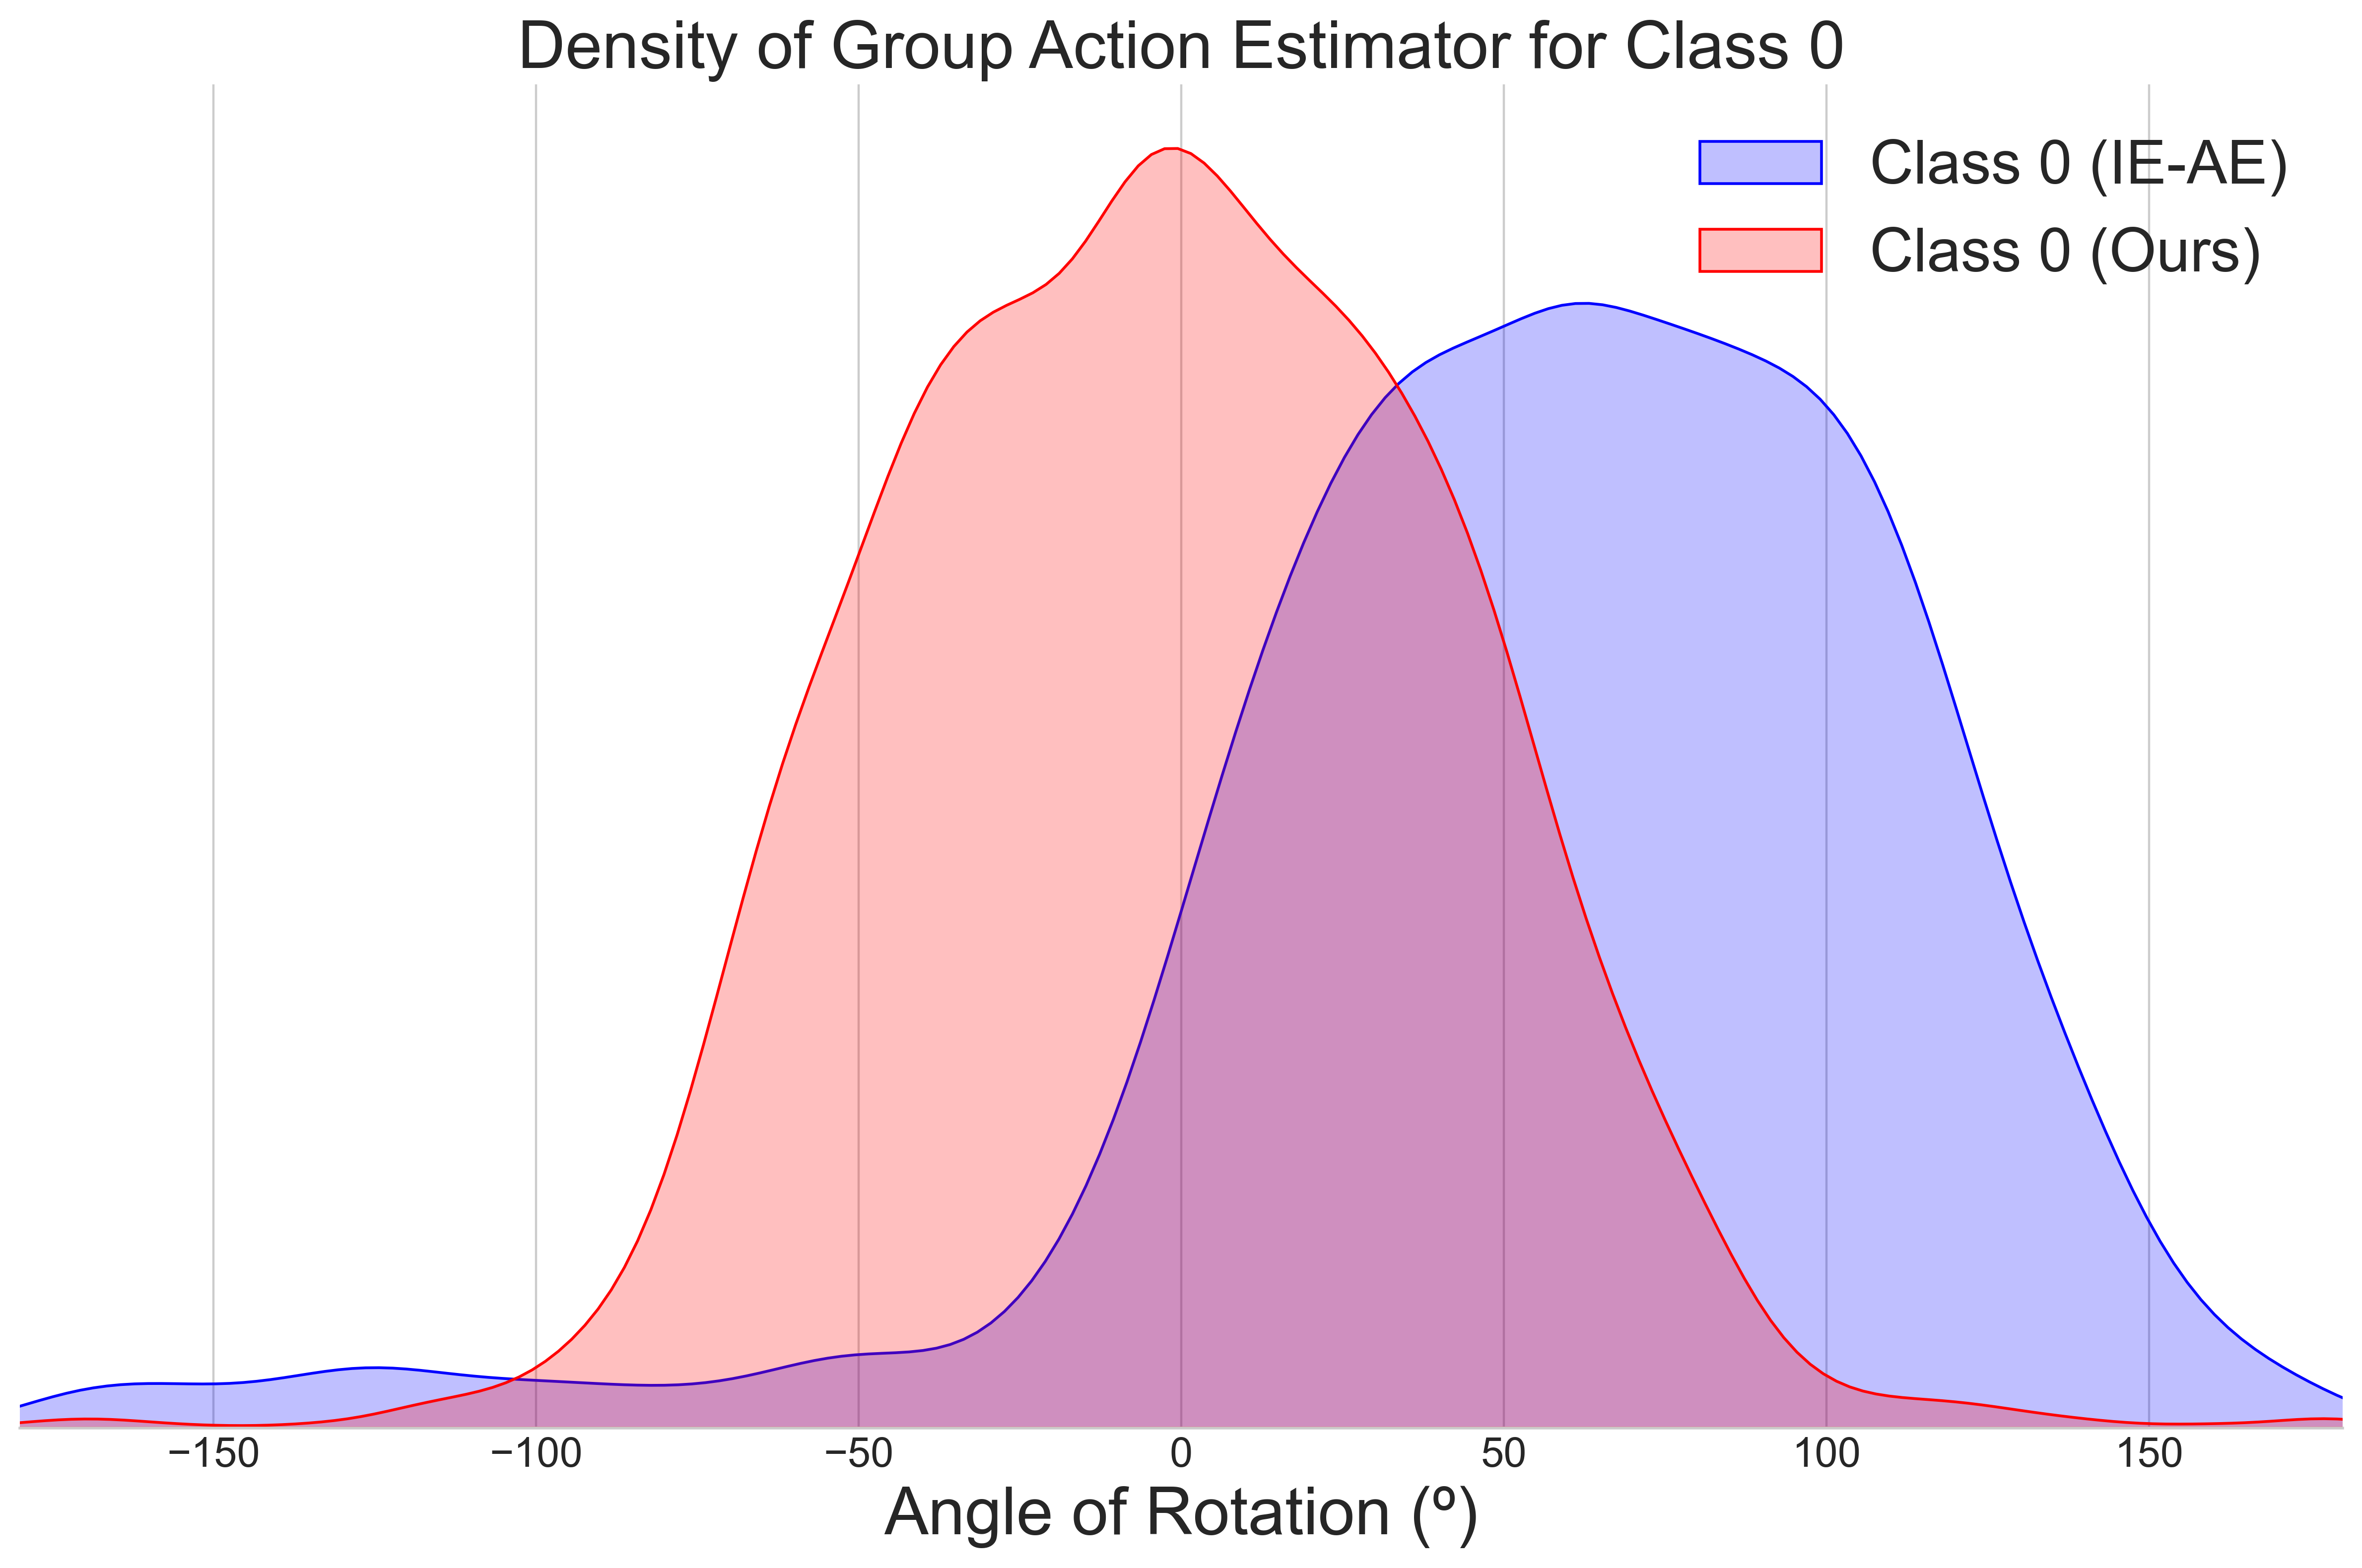

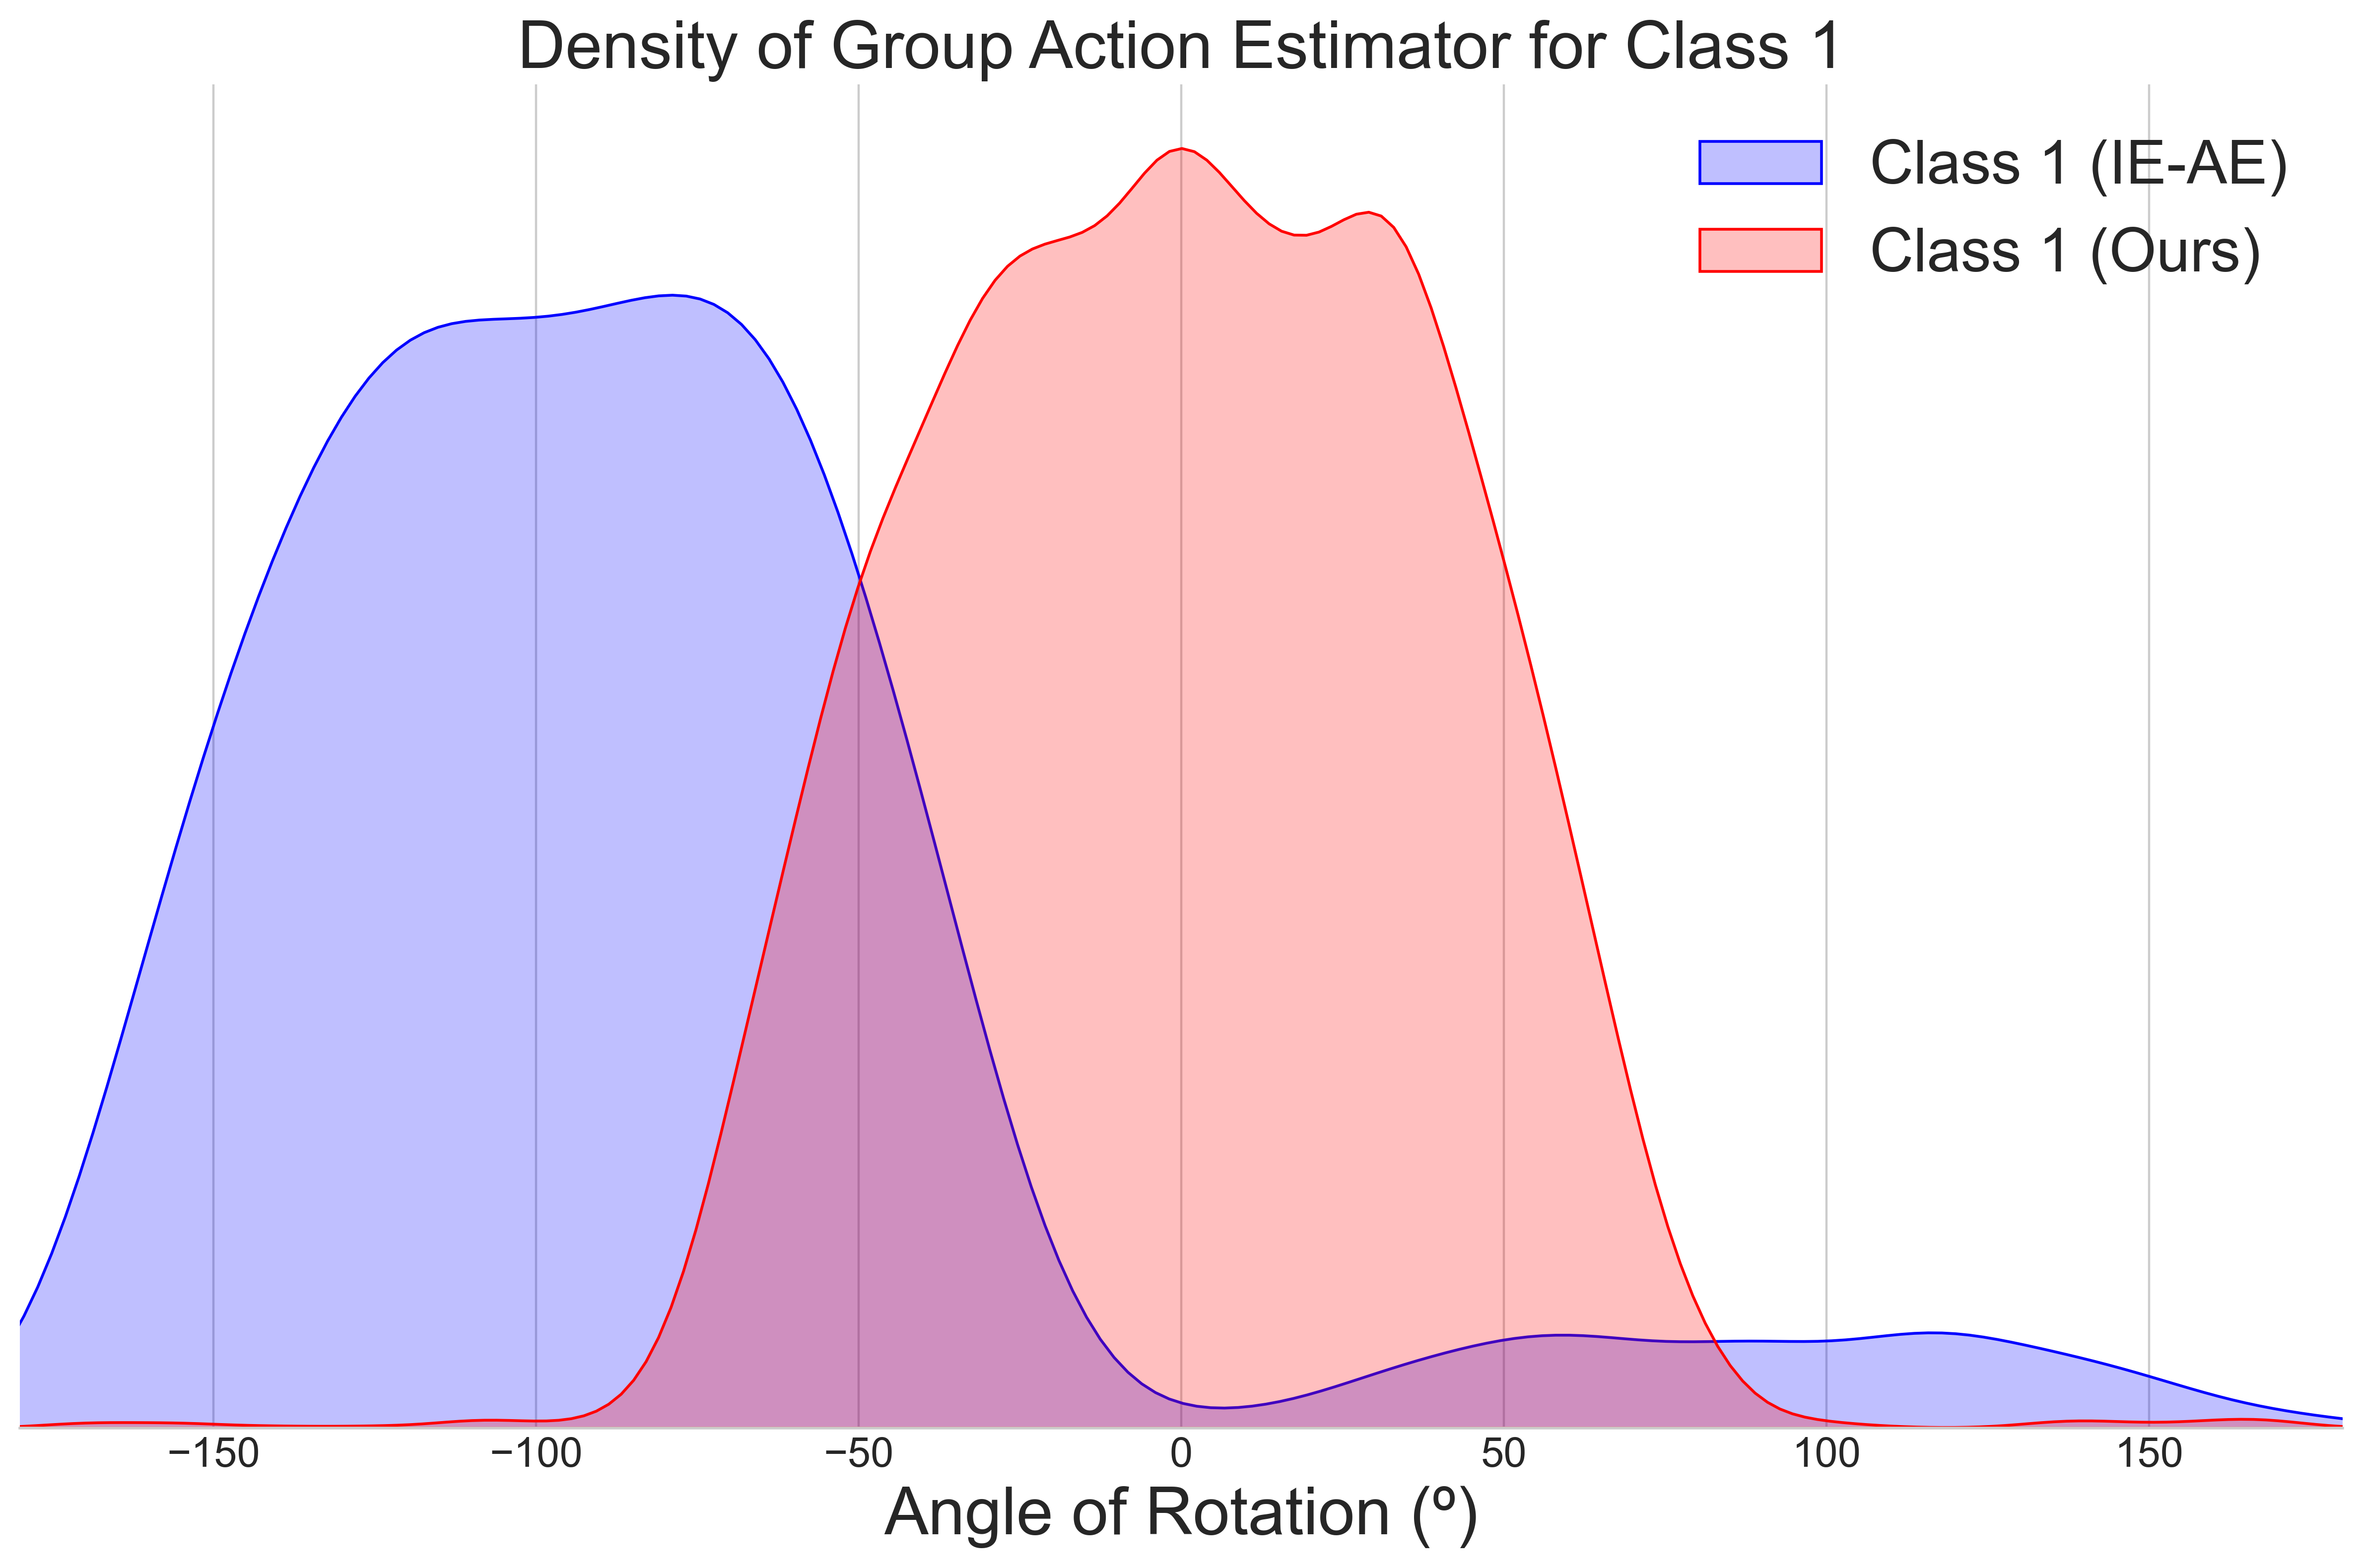

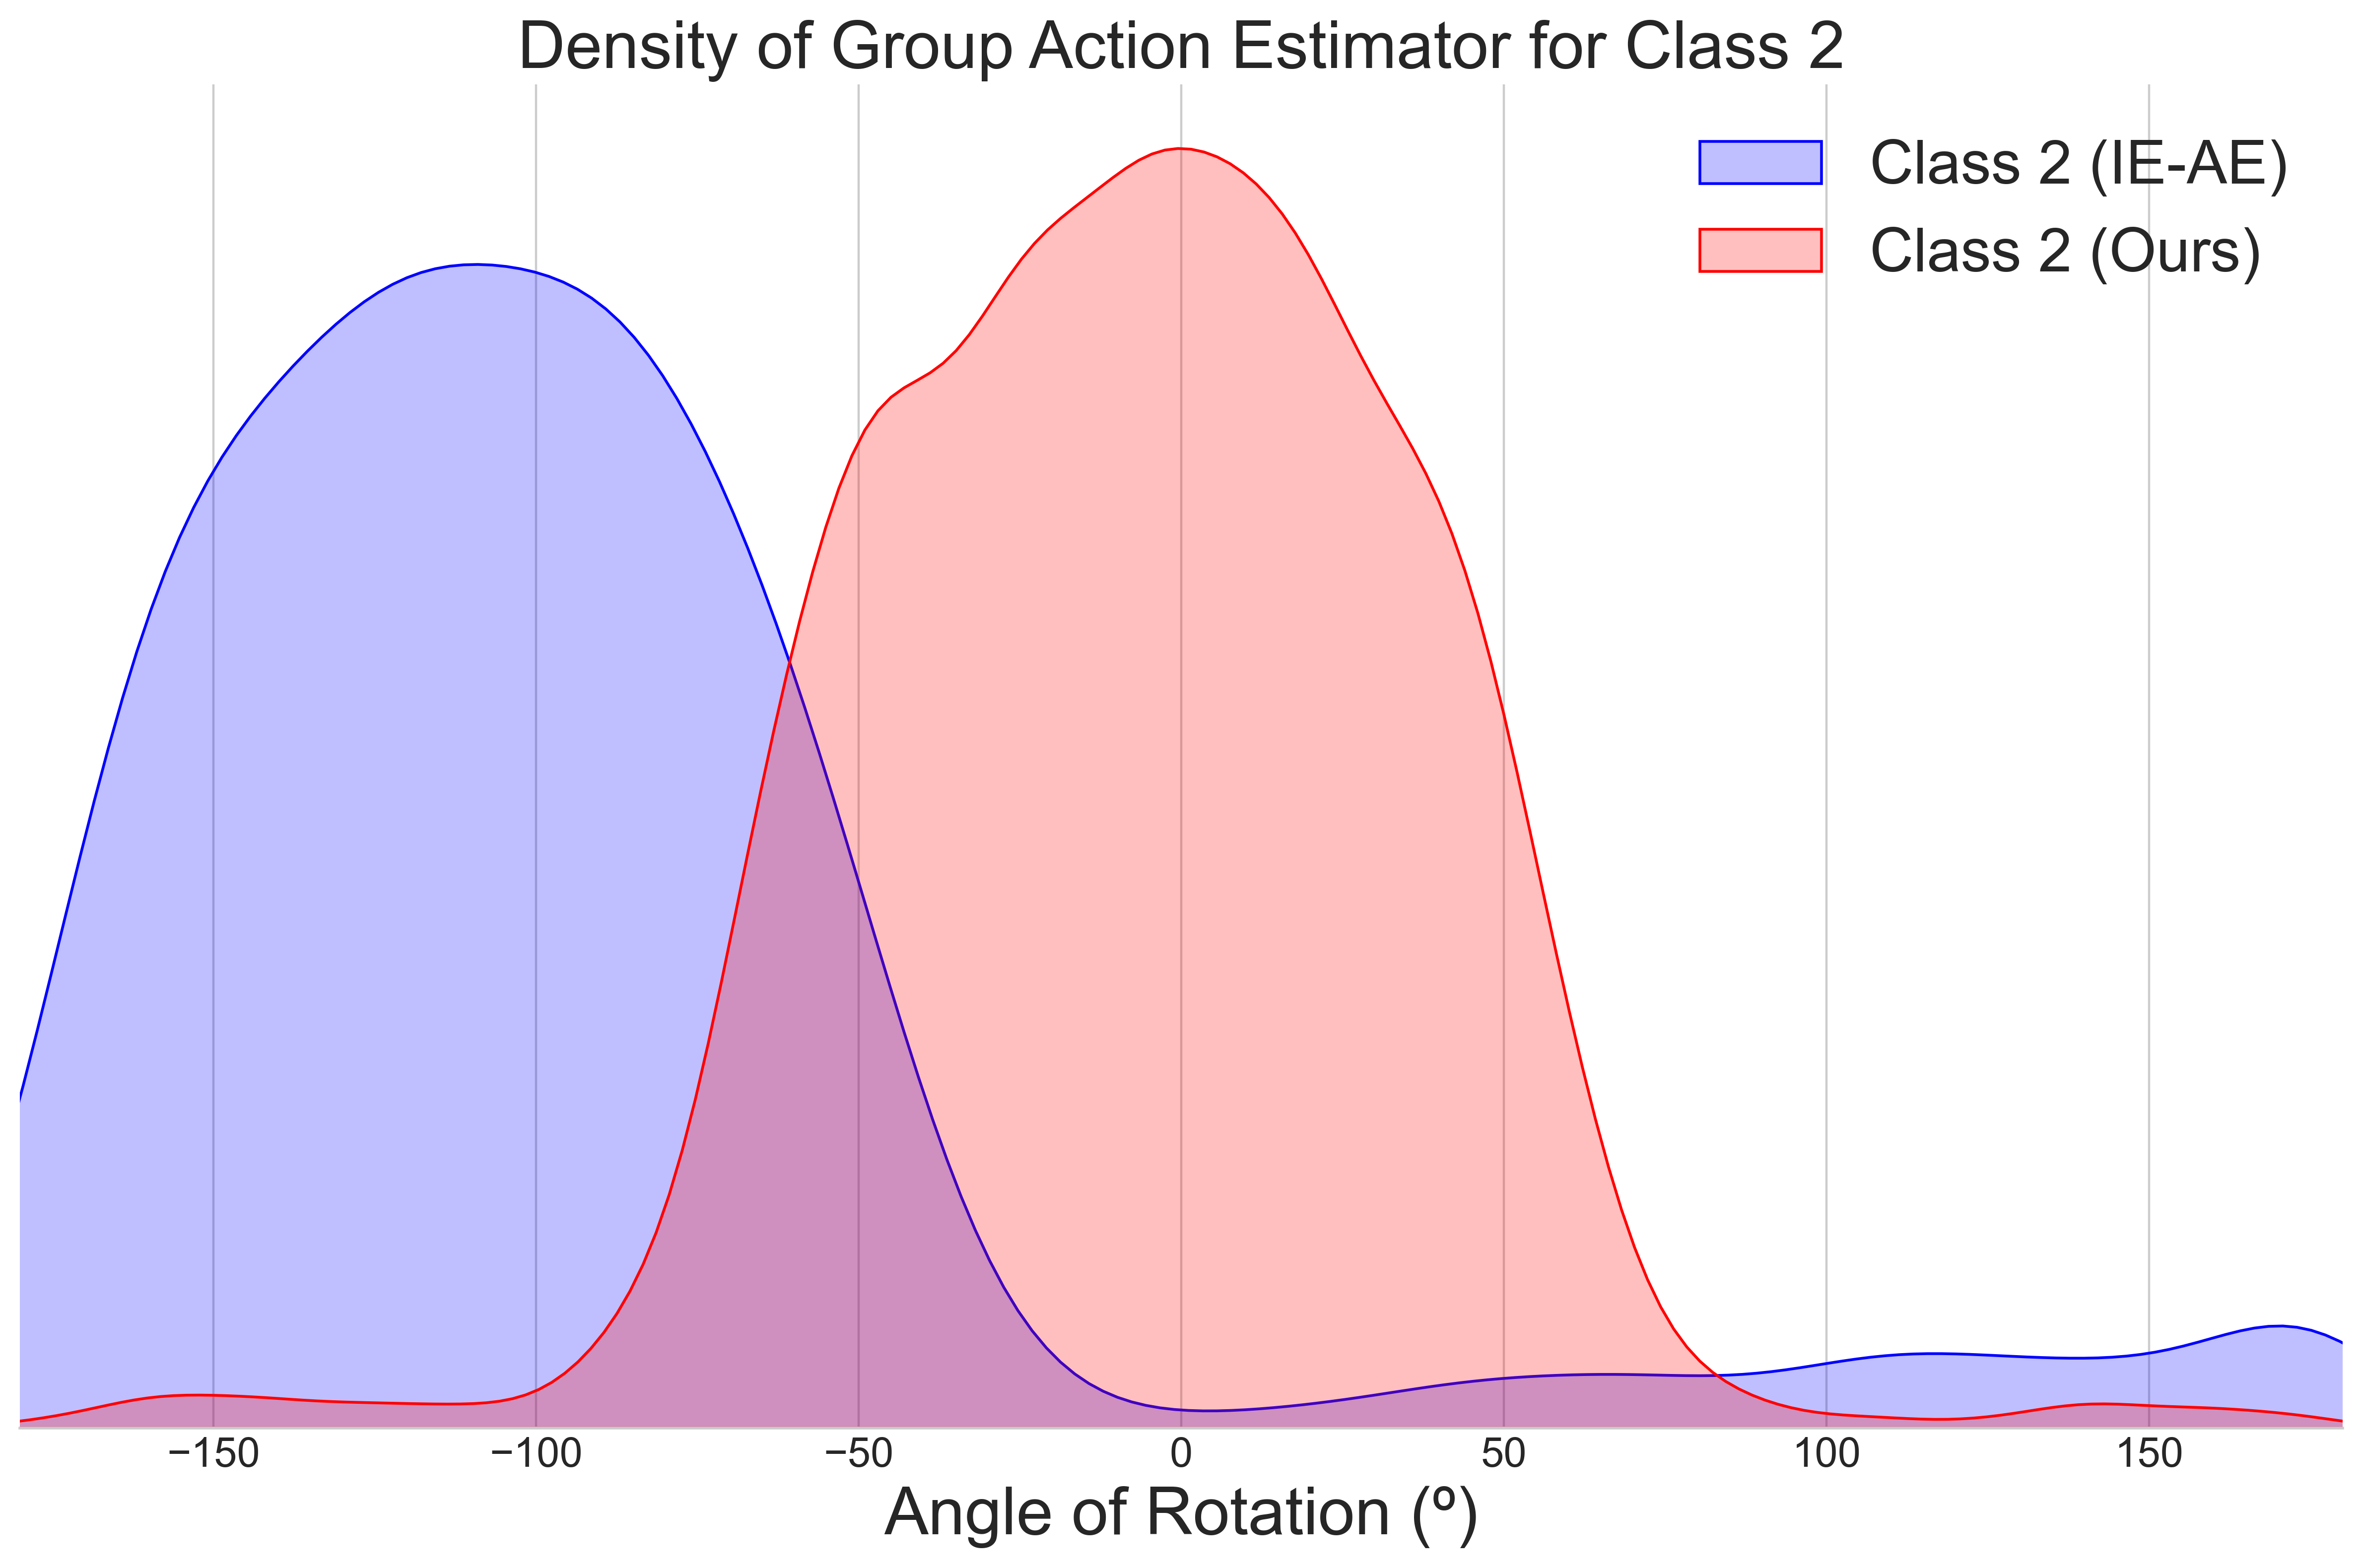

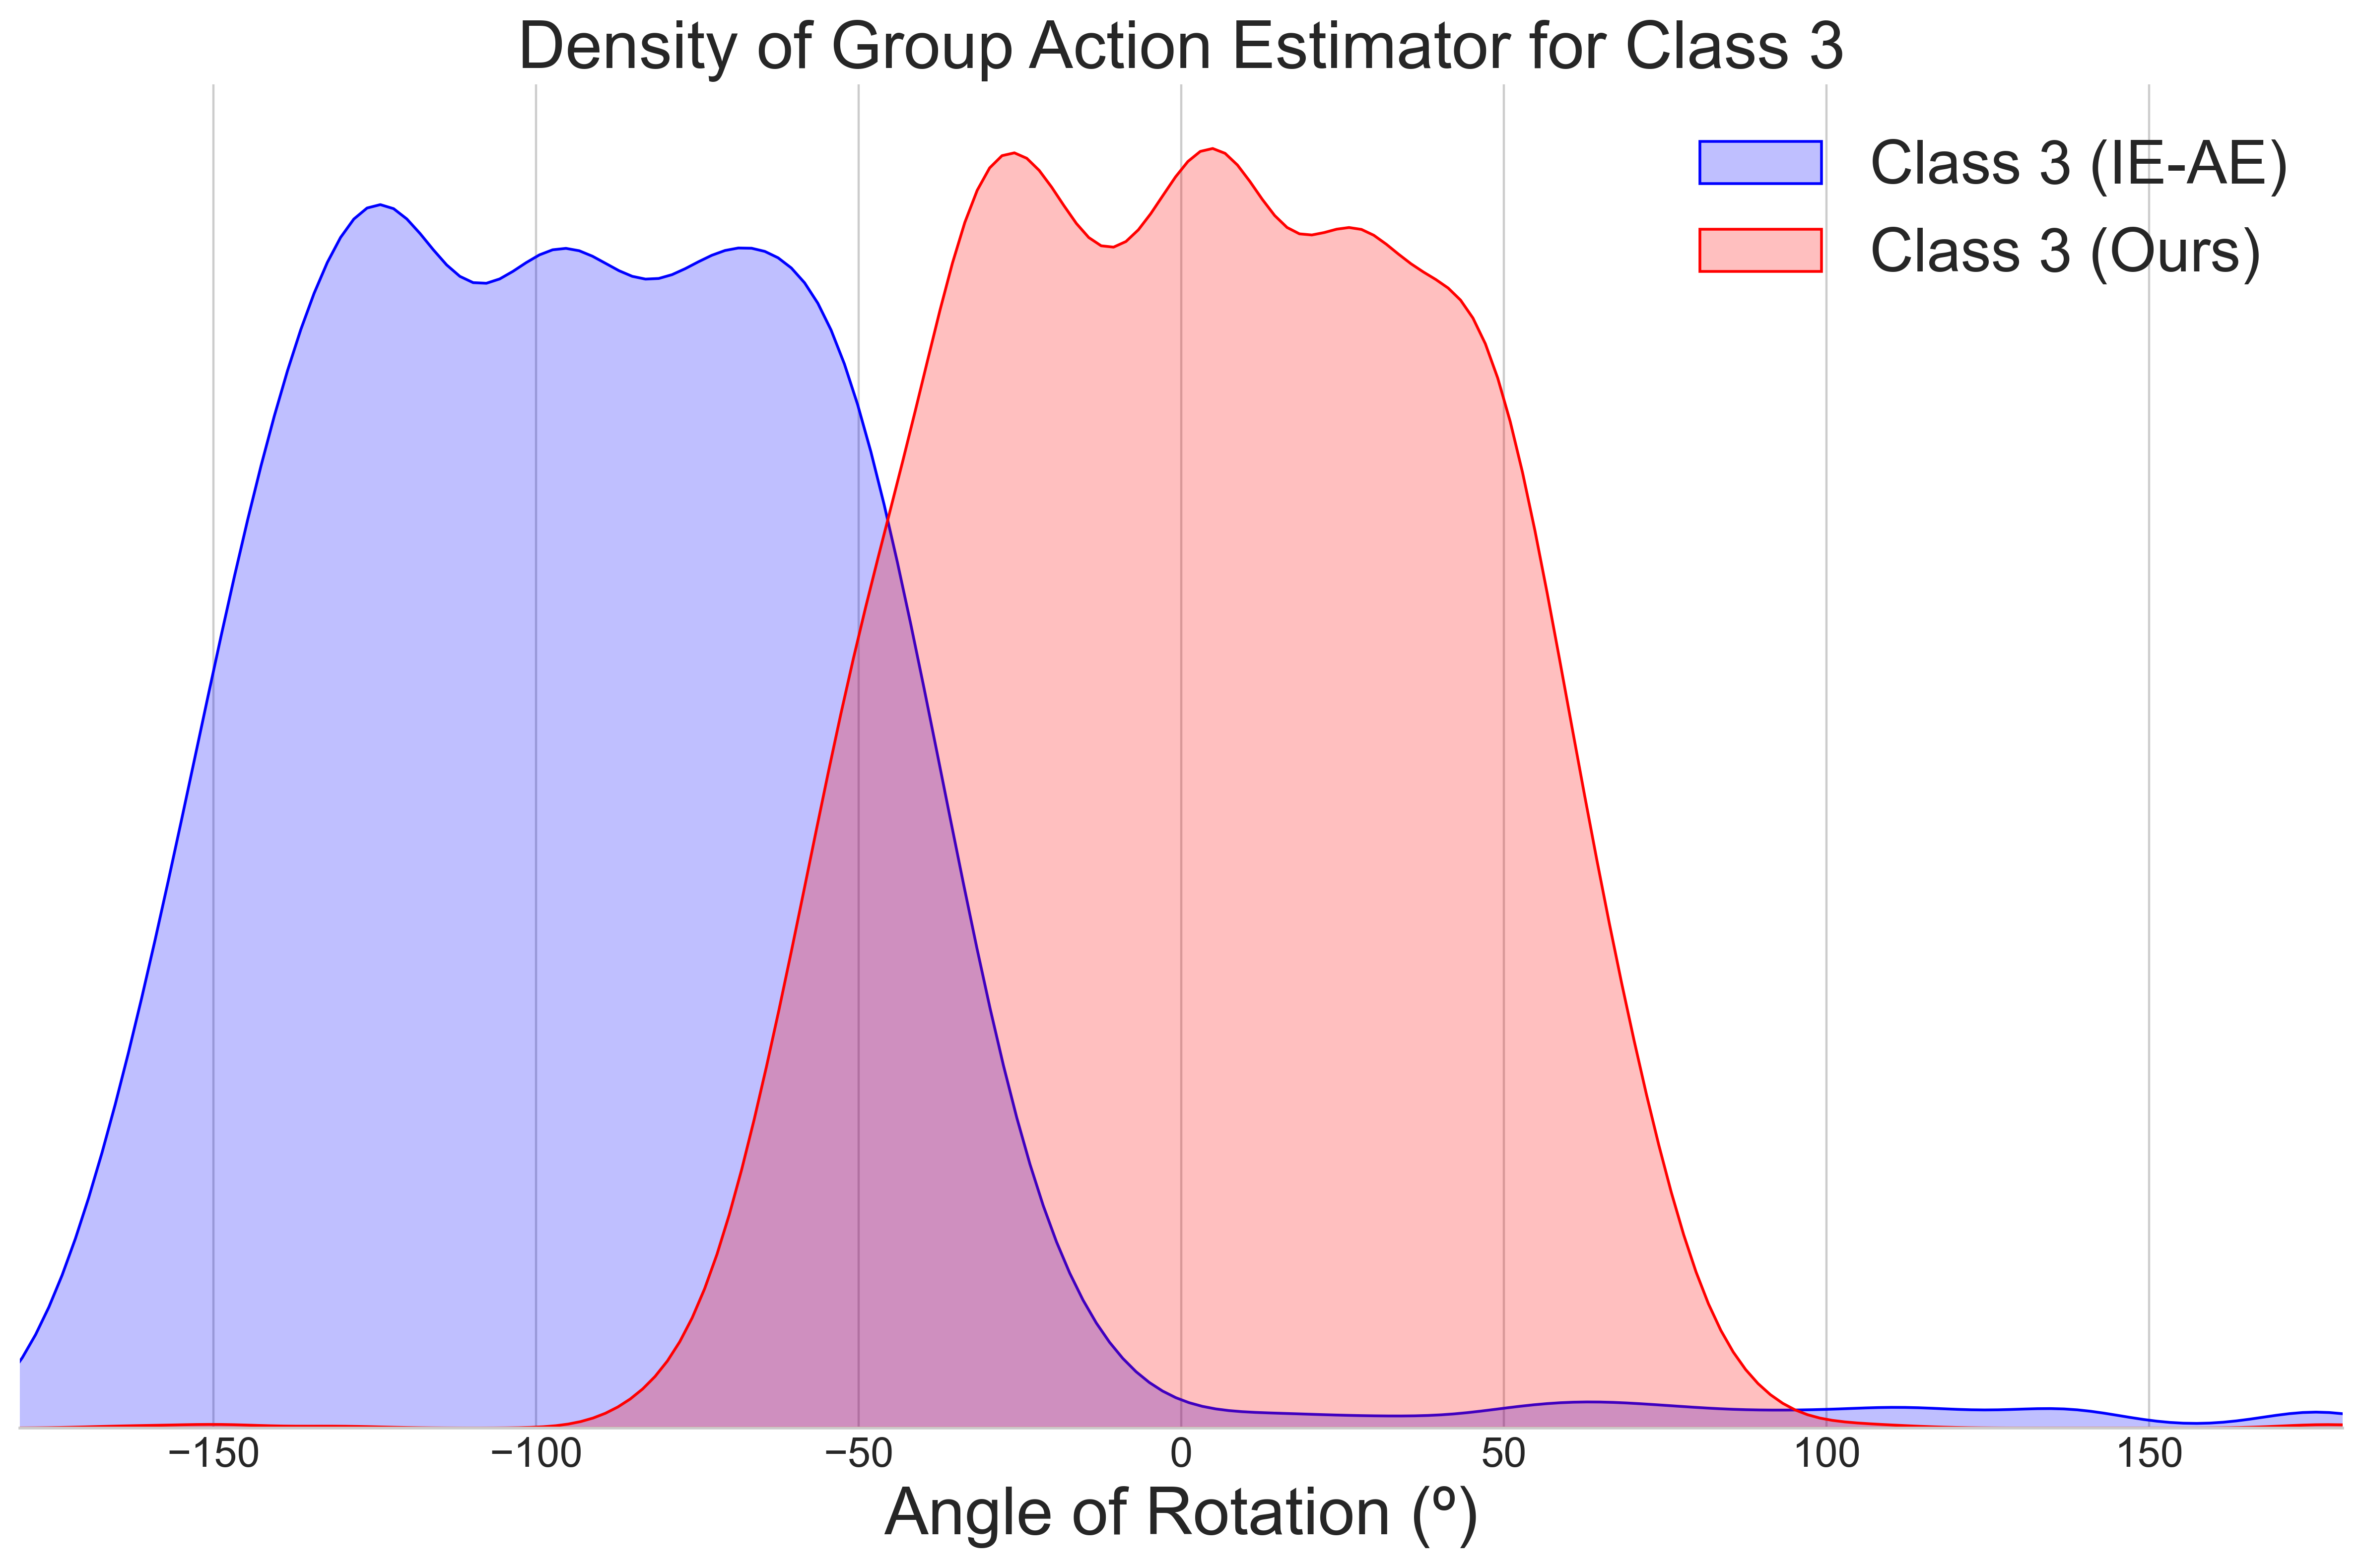

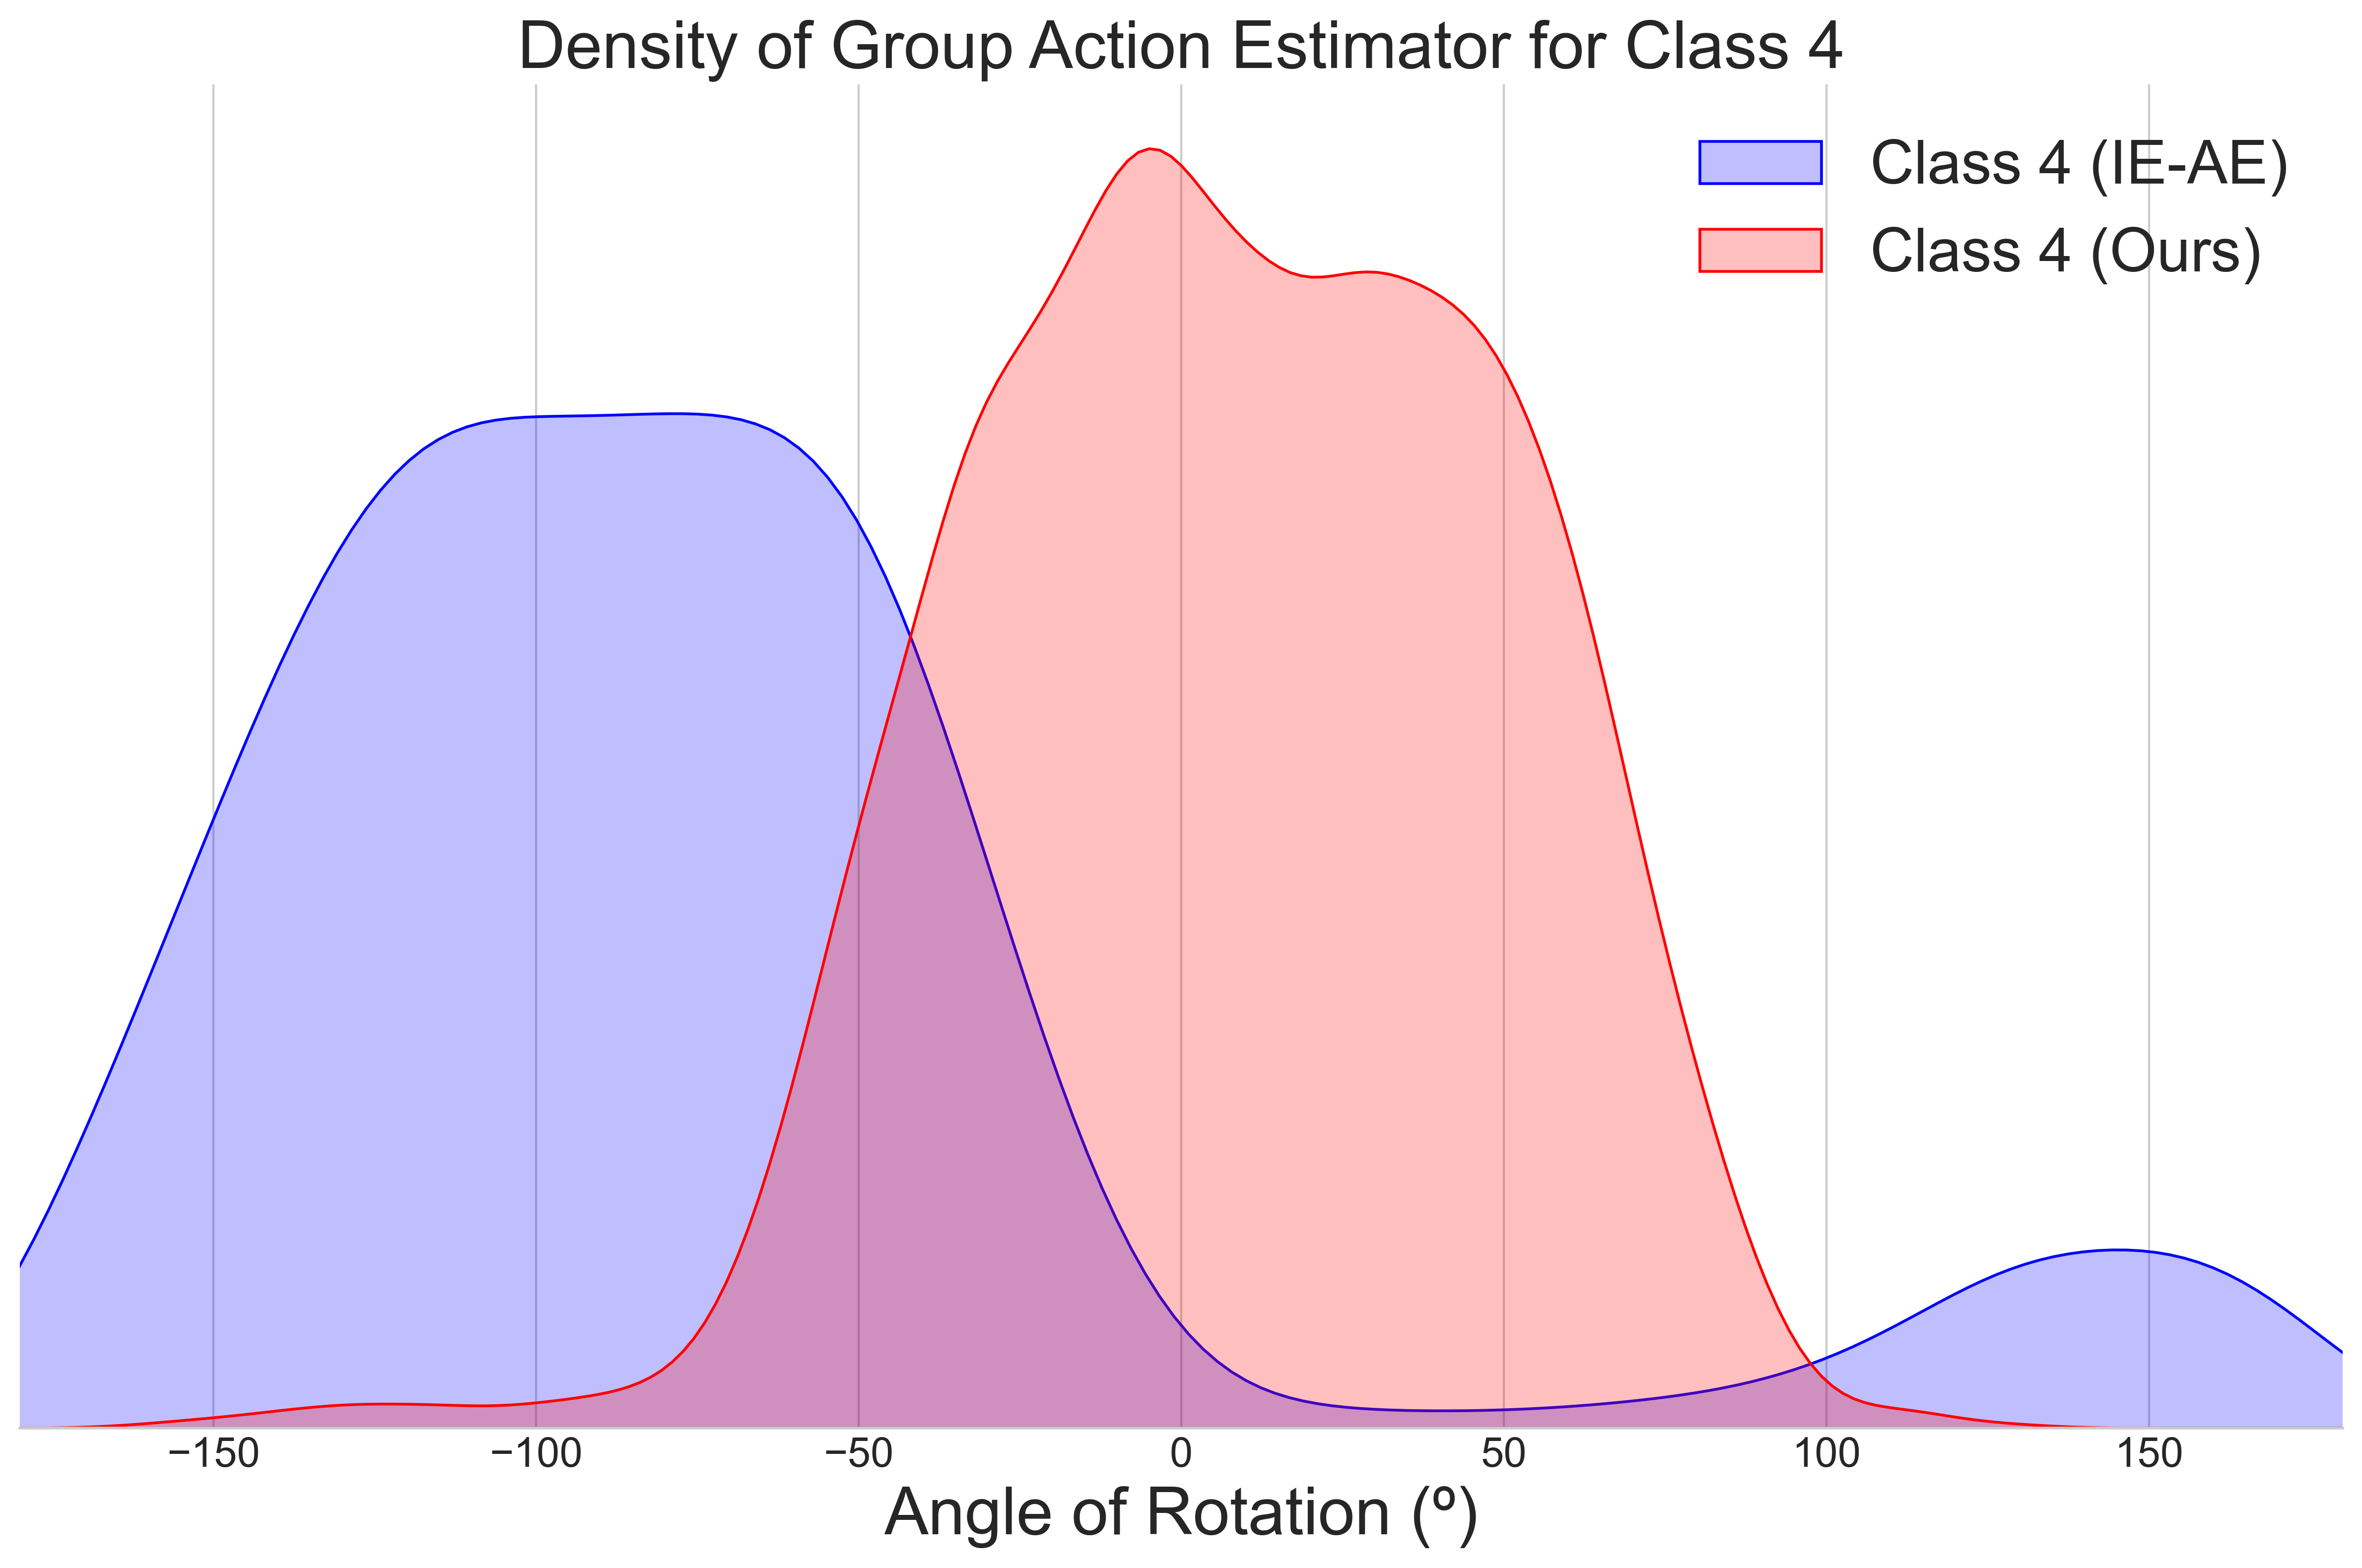

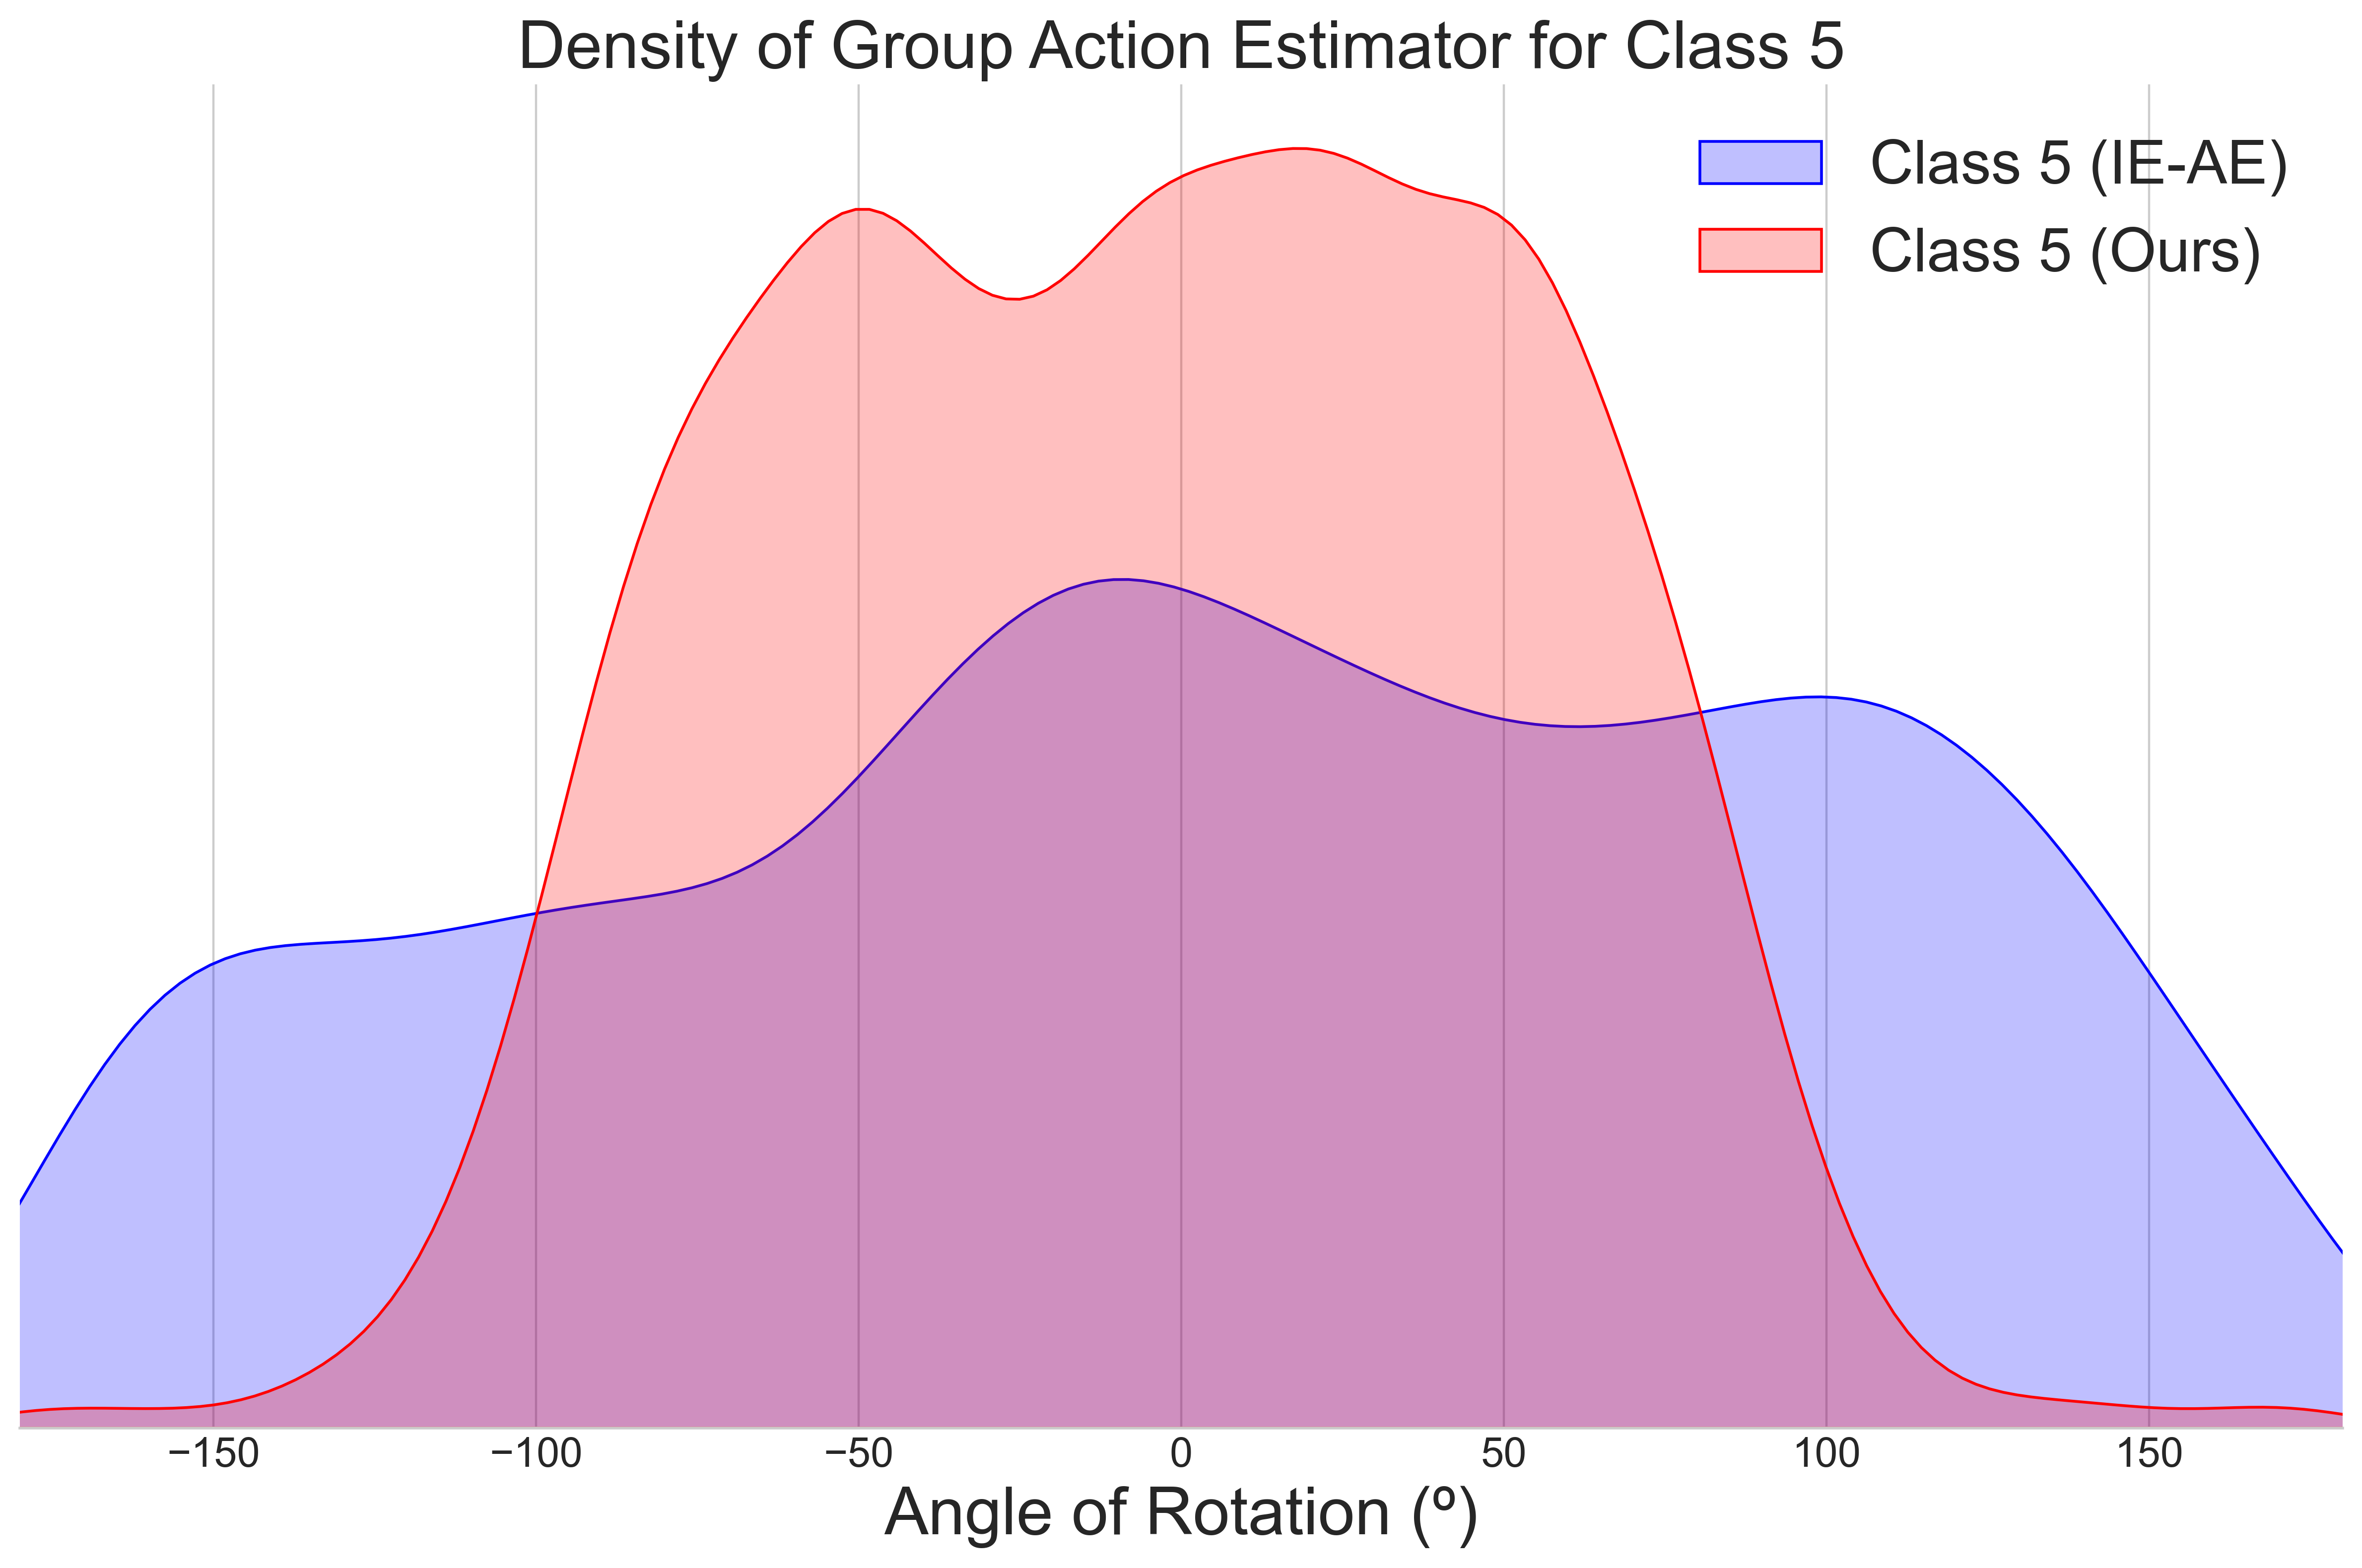

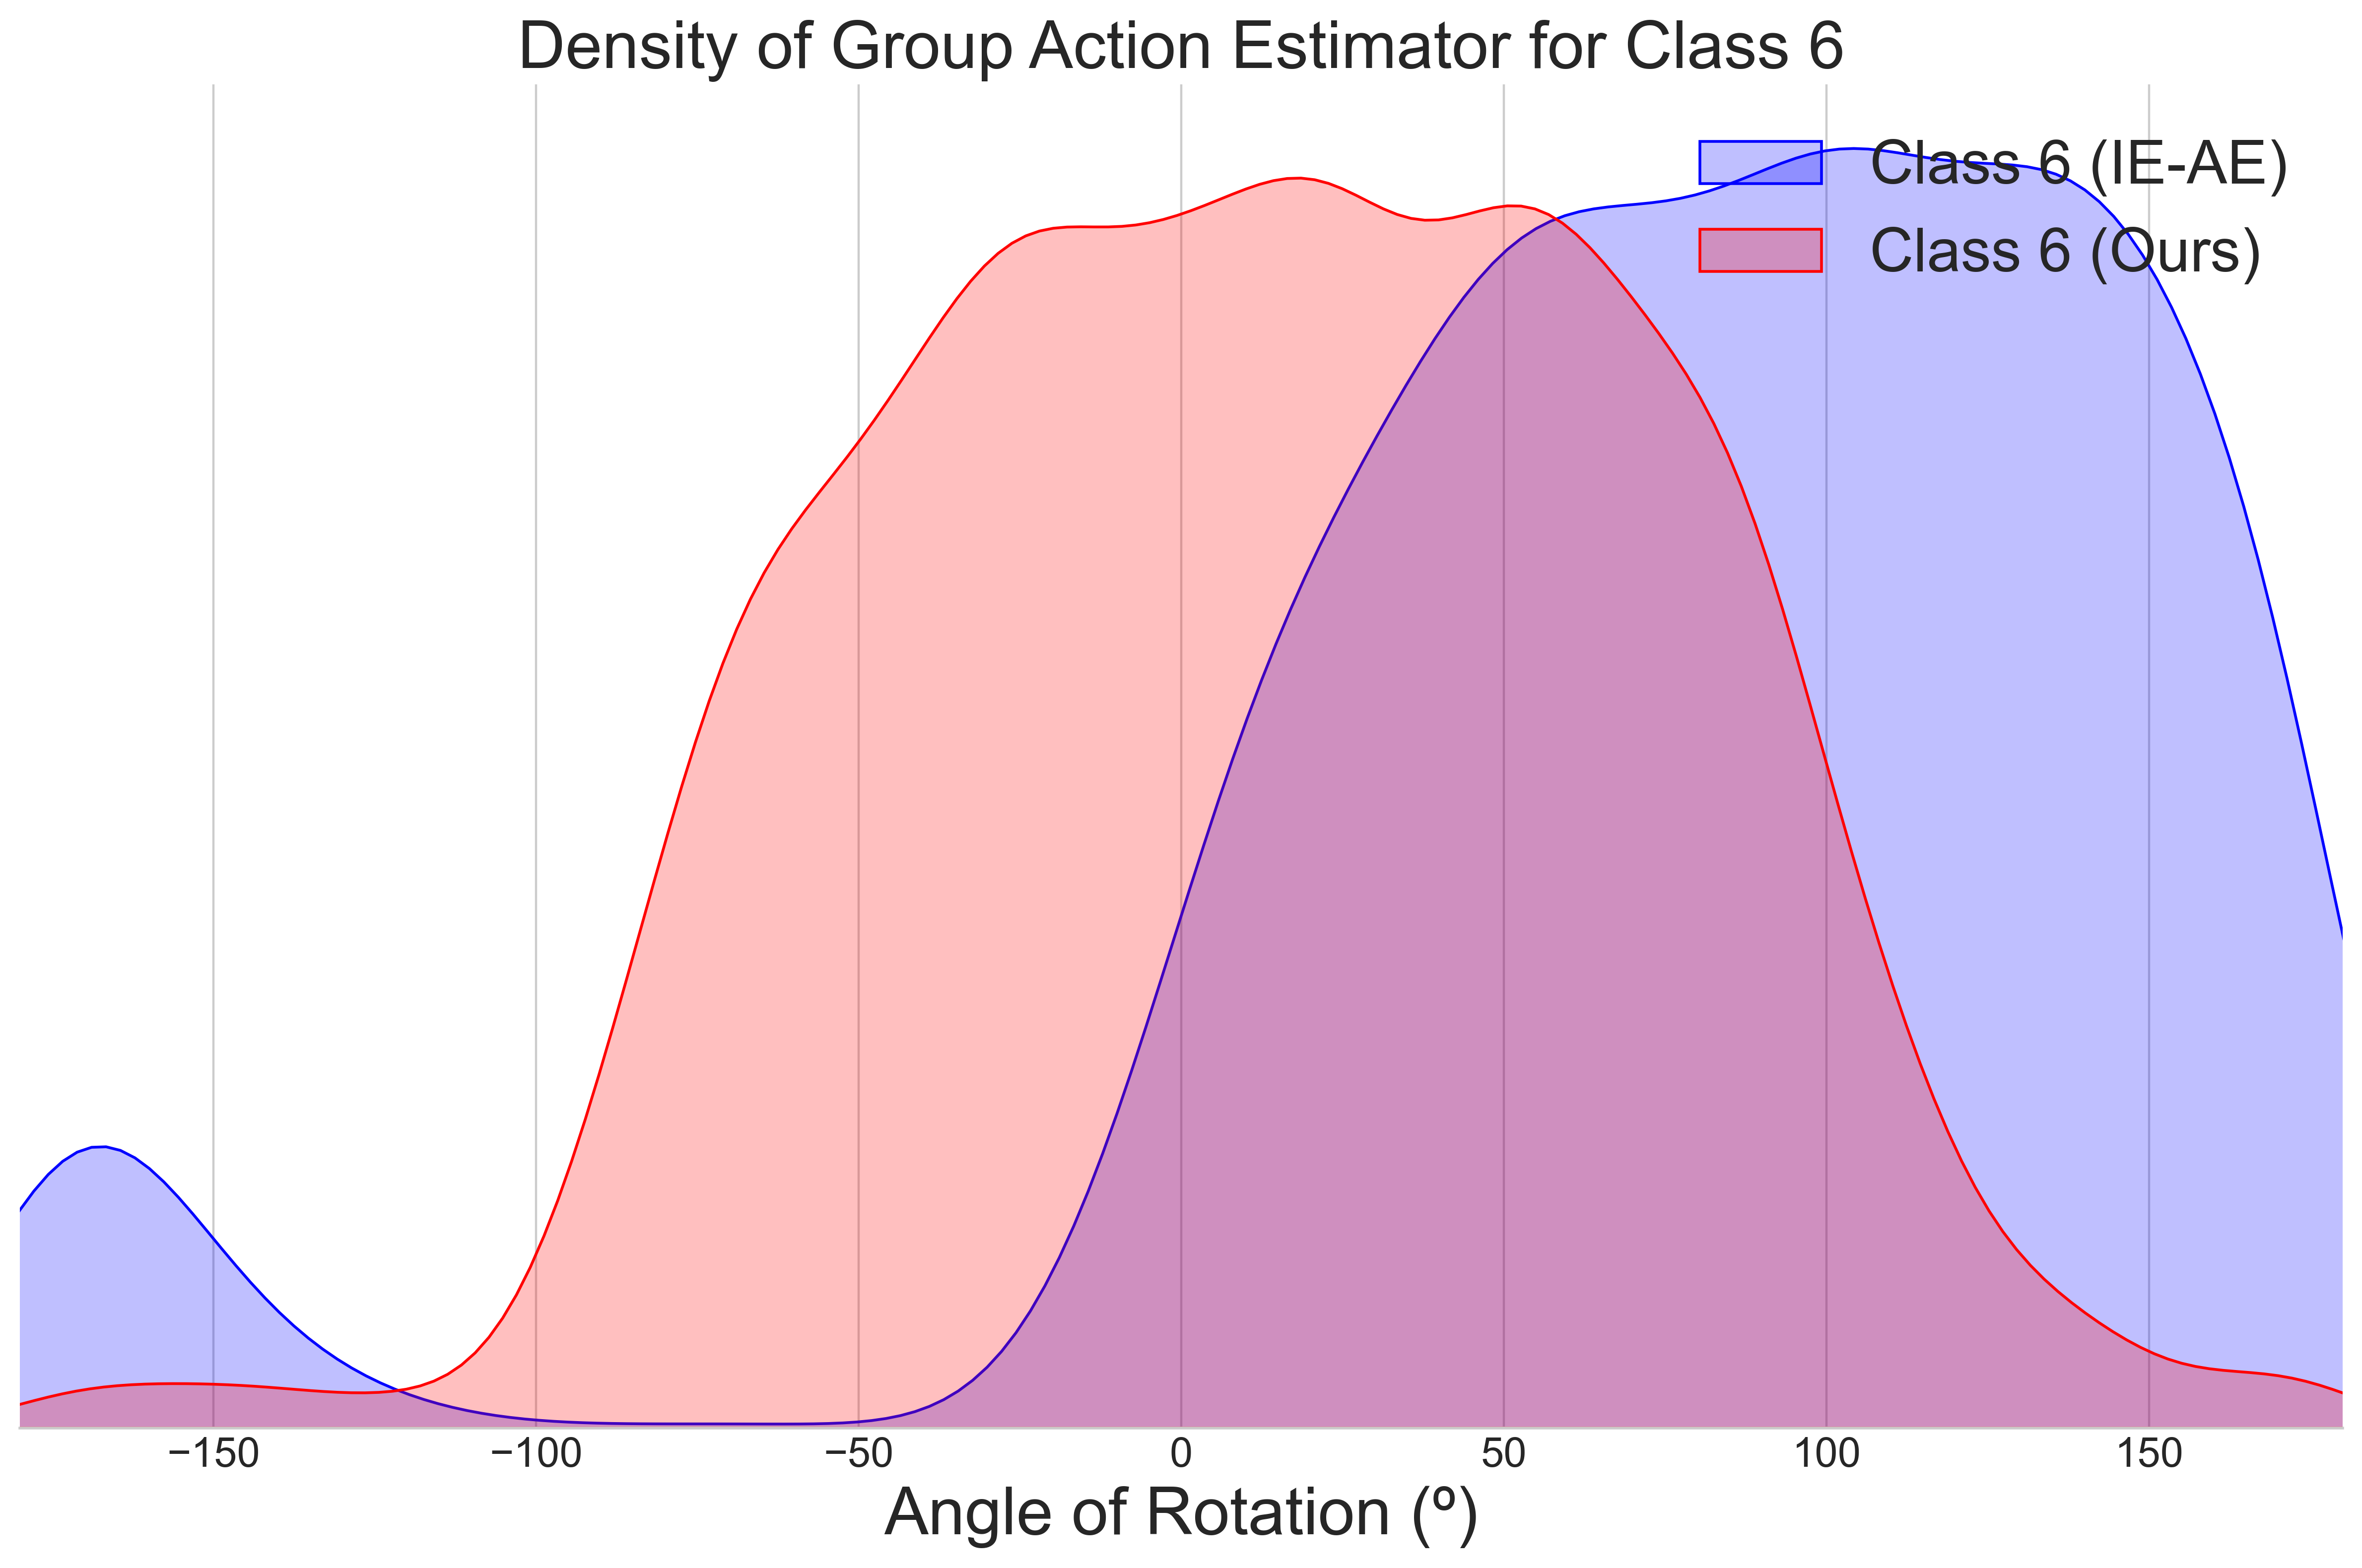

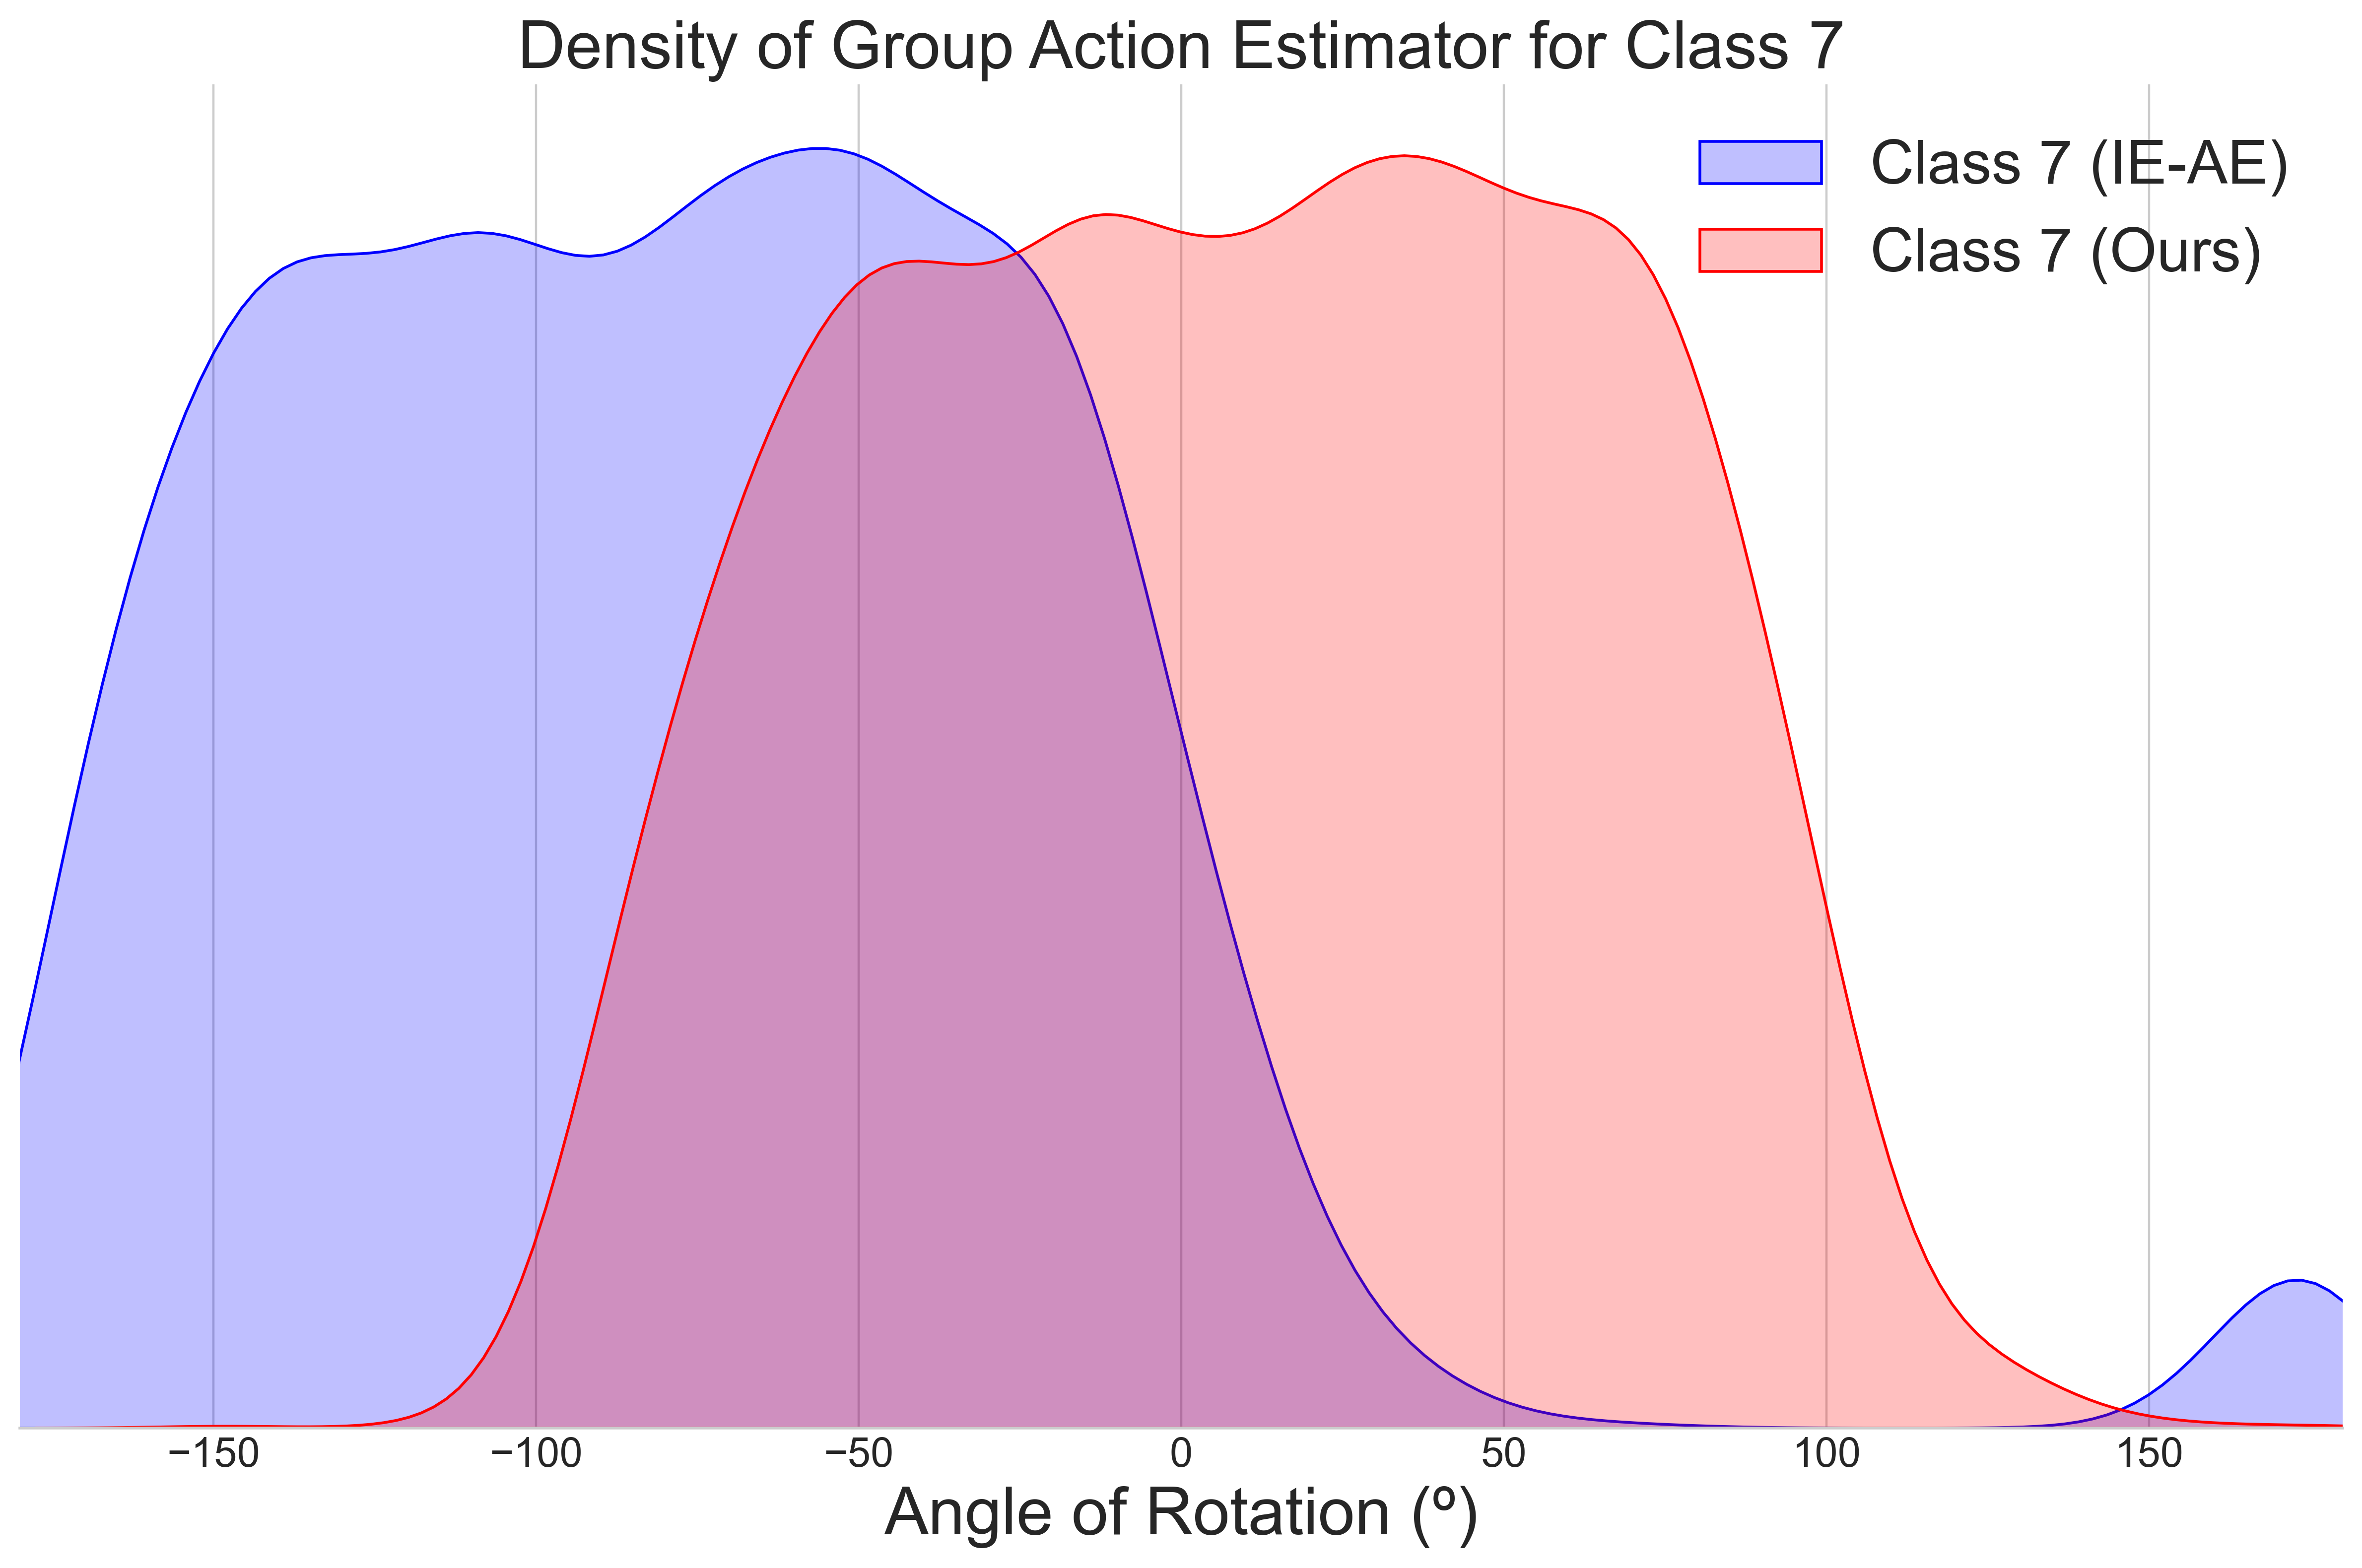

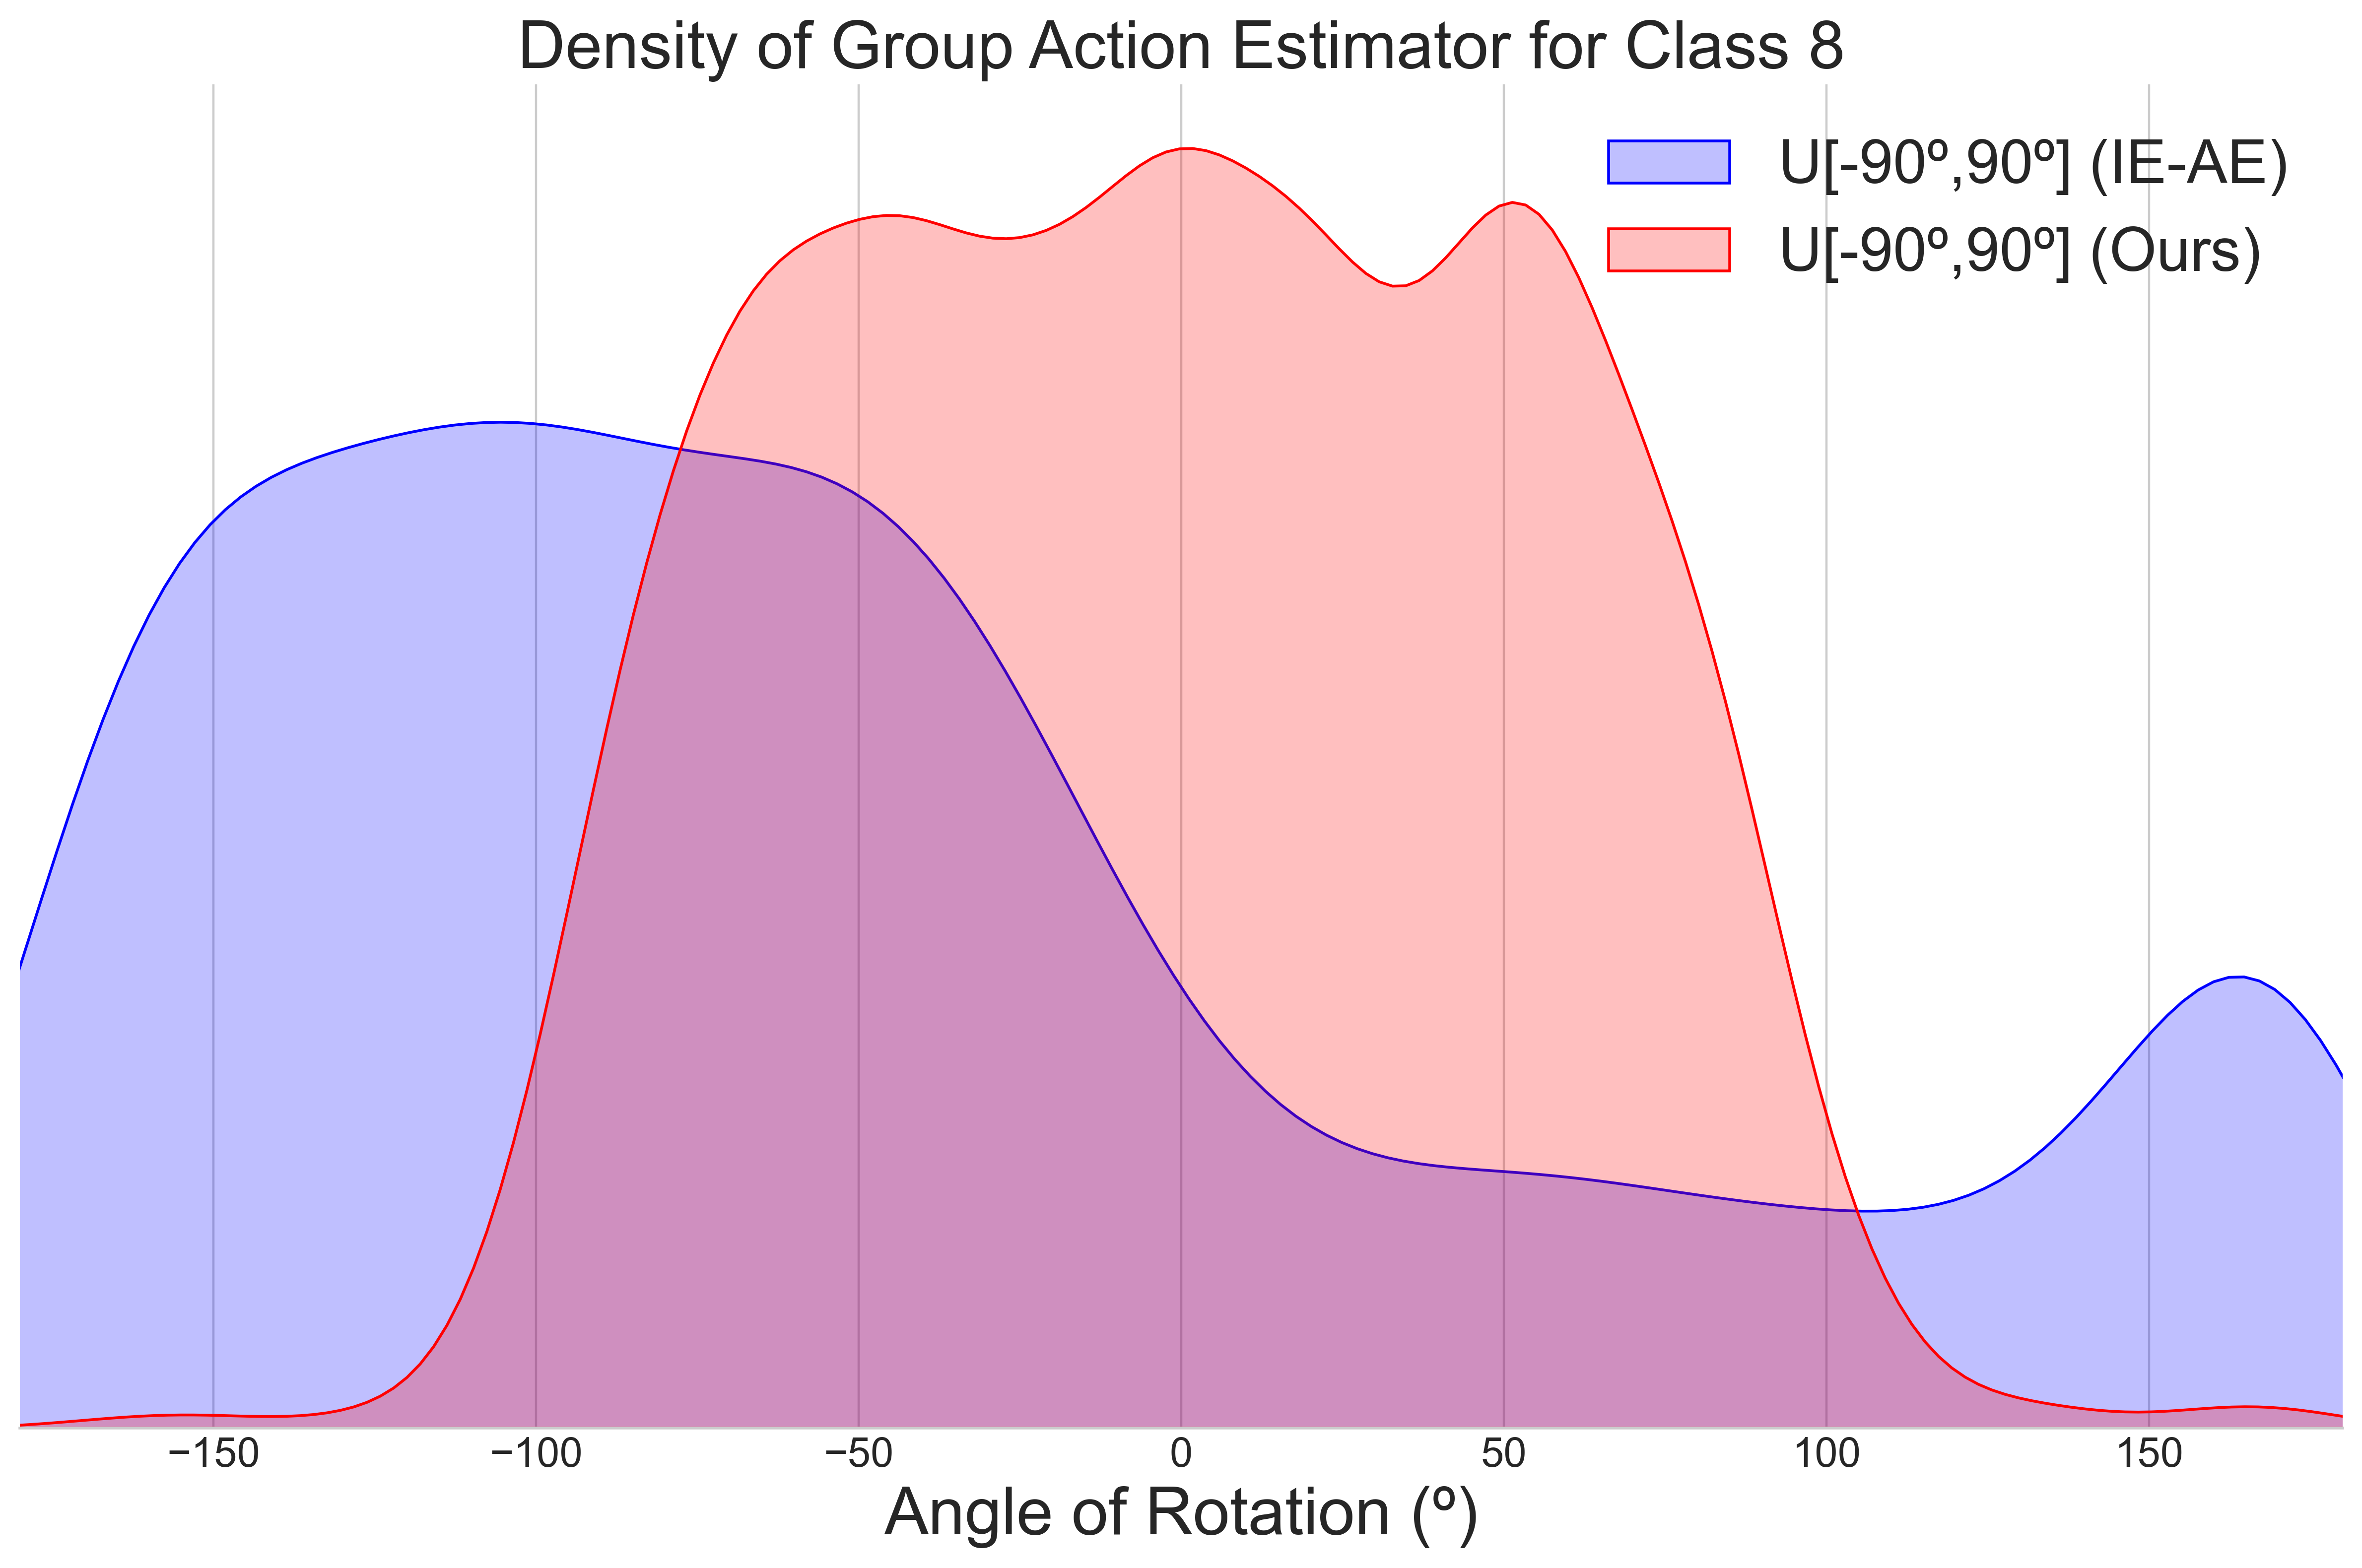

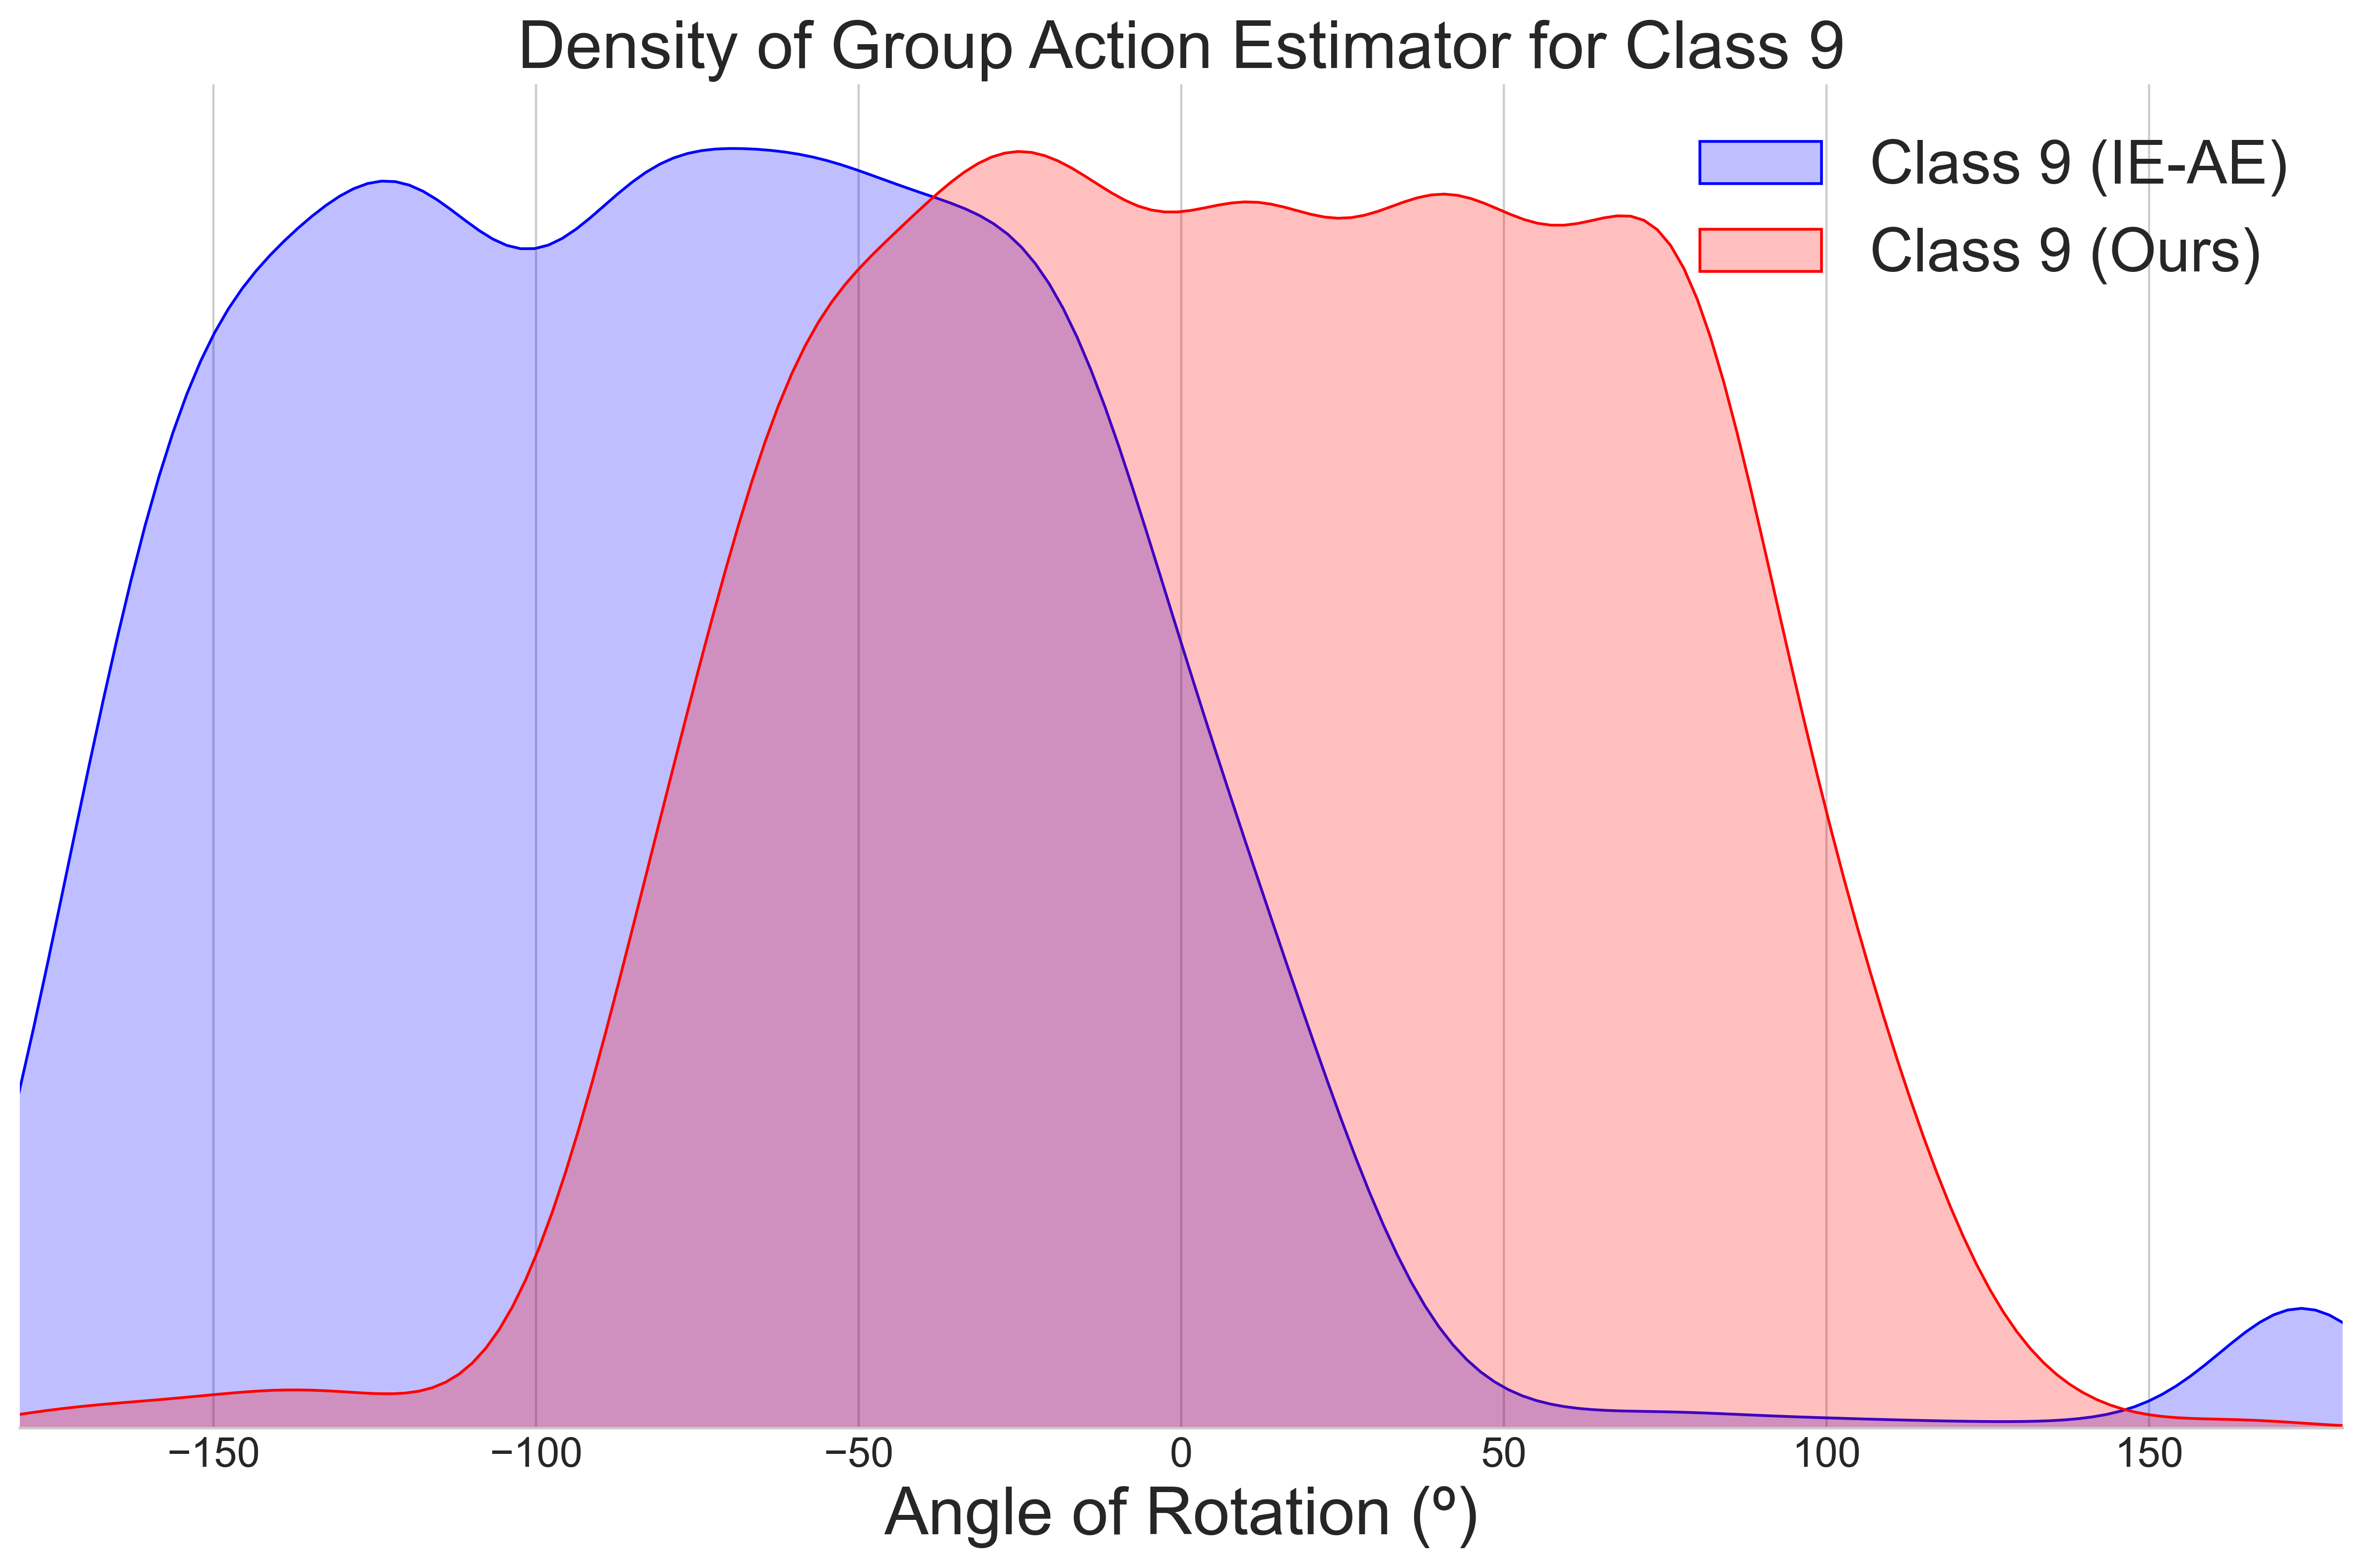

In [11]:
# Densities Plot

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams["mathtext.default"]

# Load the data for different classes
for digit in range(10):
    plt.figure(figsize=(12, 8), dpi=400)
    df = pd.read_csv(f"./plots/{EXPERIMENT}_IE-AE_COMPARISON/rotations_class_{str(digit)}.csv") 
    df_ieae = pd.read_csv(f"./plots/{EXPERIMENT}_IE-AE_COMPARISON/ieae_rotations_class_{str(digit)}.csv")
    if digit!=8:
        # Plot KDE for each class
        sns.kdeplot(df_ieae['psi'], fill=True, color="b", label=f"Class {digit} (IE-AE)")
        sns.kdeplot(df['psi'], fill=True, color="r", label=f"Class {digit} (Ours)")
    else:
        # Plot KDE for each class
        sns.kdeplot(df_ieae['psi'], fill=True, color="b", label=f"U[-90º,90º] (IE-AE)")
        sns.kdeplot(df['psi'], fill=True, color="r", label=f"U[-90º,90º] (Ours)")
    
    plt.xlabel("Angle of Rotation (º)", fontsize=24)
    plt.xlim(-180, 180)
    plt.xticks(fontsize=15)
    plt.yticks([])
    plt.ylabel("")
    plt.title(f"Density of Group Action Estimator for Class {digit}", fontsize=24)
    plt.legend(fontsize='22')

    sns.despine(left=True)
    plt.tight_layout()
    plt.savefig(f"./plots/{EXPERIMENT}_IE-AE_COMPARISON/density_comparison_class_{str(digit)}.png", dpi=400)
    plt.show()

In [12]:
%%capture
# Load IE-AE model again
if "MNIST" in EXPERIMENT:
        config.in_channels = 1
        config.emb_dim_theta = 128
        config.hidden_dim_theta = 64
        num_classes = 10
        if EXPERIMENT == "ROTMNIST60-90":
            config.customdata_test_path = "../datasets/mnist60_90_test.pkl"
            config.pretrained_path = "../models/ie-ae/mnist6090/best_model_theta.pt"
            # Net
            config.hidden_dim = 64
            config.emb_dim = 200
        if EXPERIMENT == "MNISTMULTIPLE":
            config.customdata_test_path = "../datasets/mnist_multiple_test.pkl"
            config.pretrained_path = "../models/ie-ae/mnistmultiple/best_model_theta.pt"
            # Net
            config.hidden_dim = 64
            config.emb_dim = 200

net = PartEqMod(hparams=config)
state_dict = torch.load(config.pretrained_path)

new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace("model.", "")  # remove "model."
    new_state_dict[name] = v
keys_to_load = {k: v for k, v in new_state_dict.items()}

print(f"Loading pre-trained model for {EXPERIMENT}.")

net.load_state_dict(keys_to_load, strict=False)
net.cuda()
net.eval()

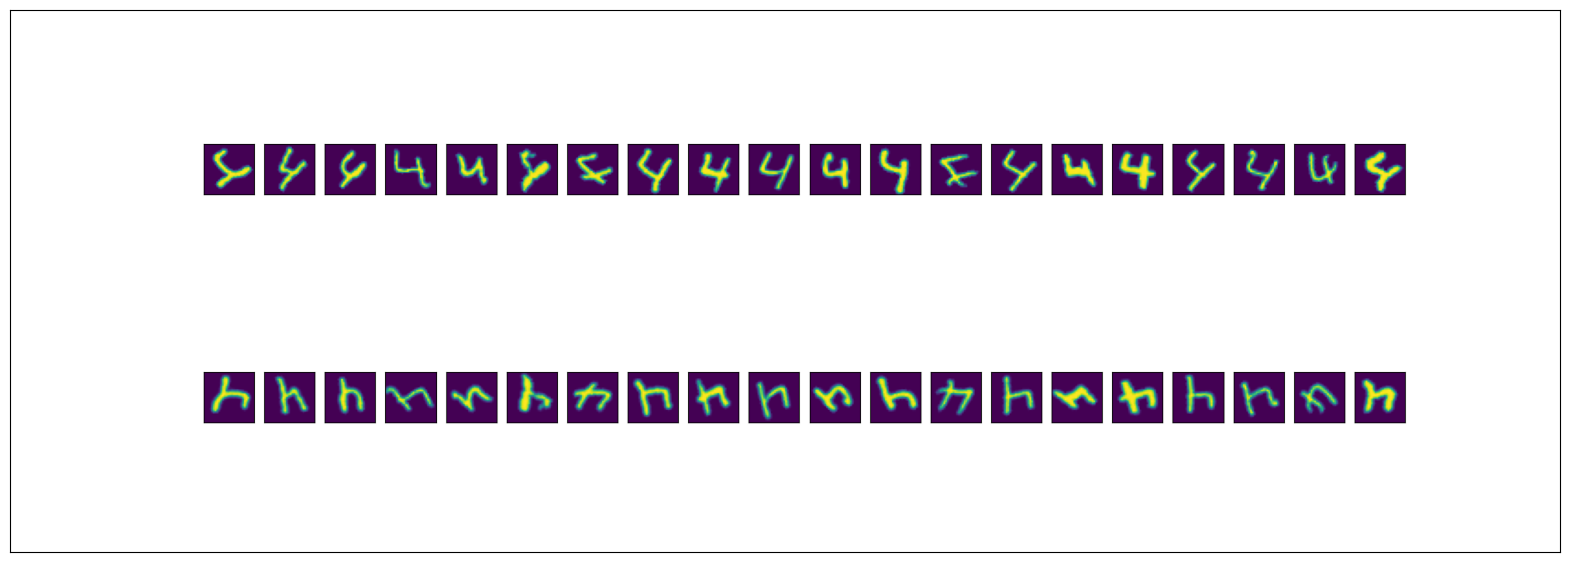

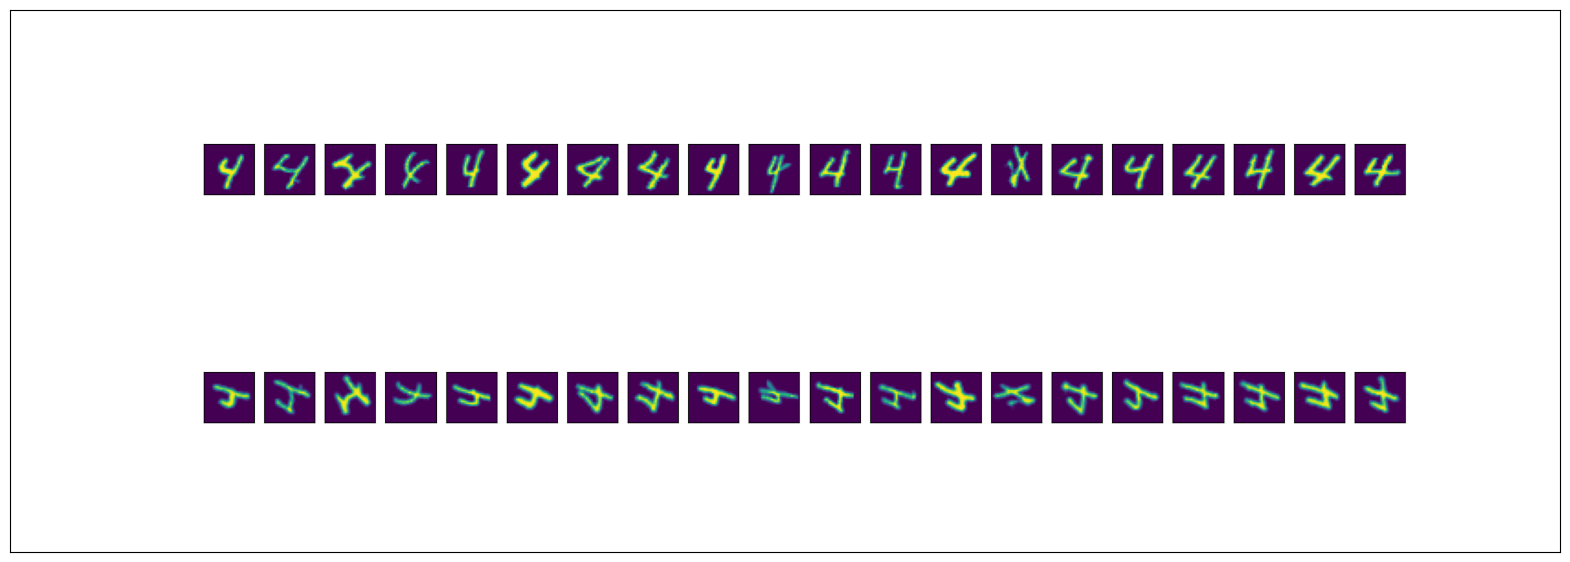

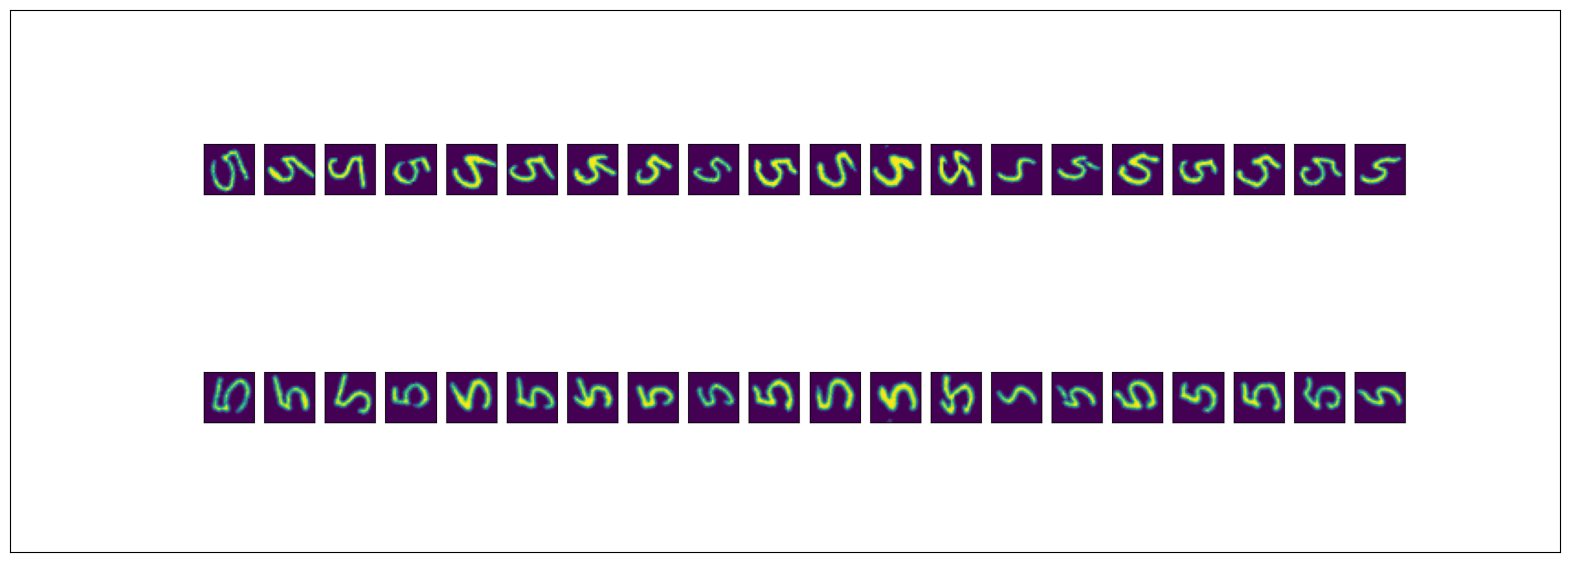

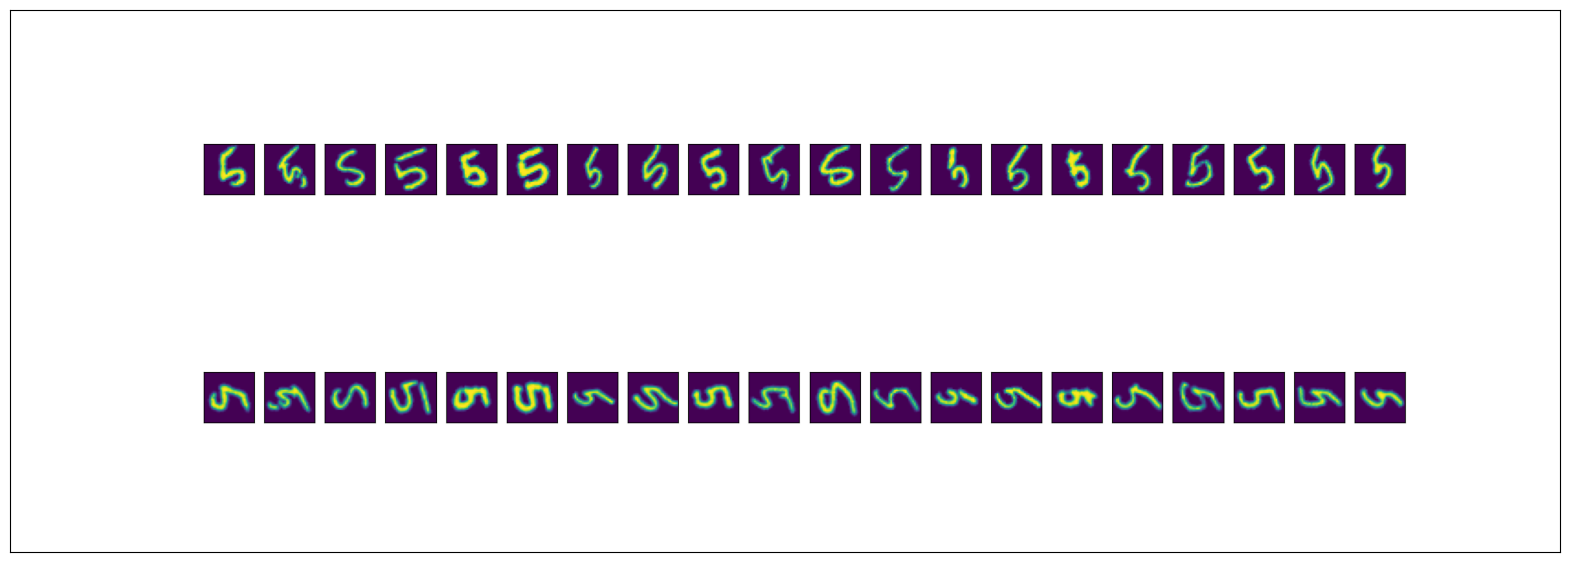

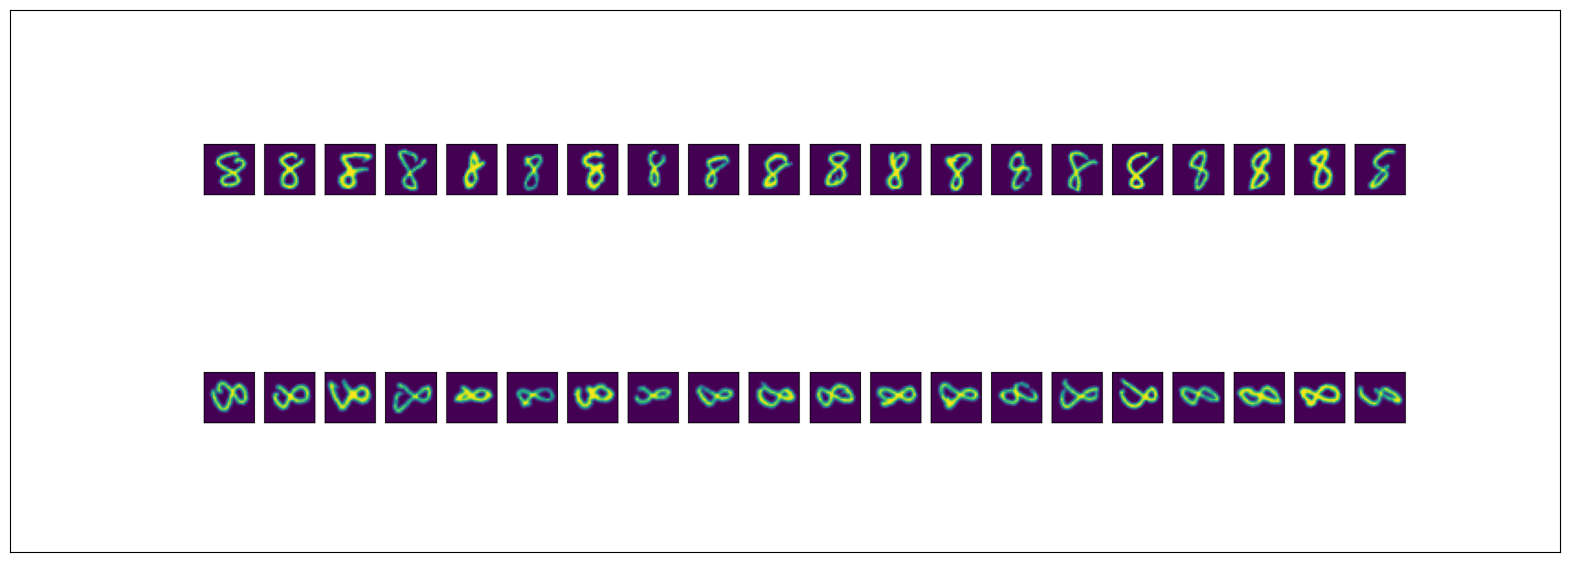

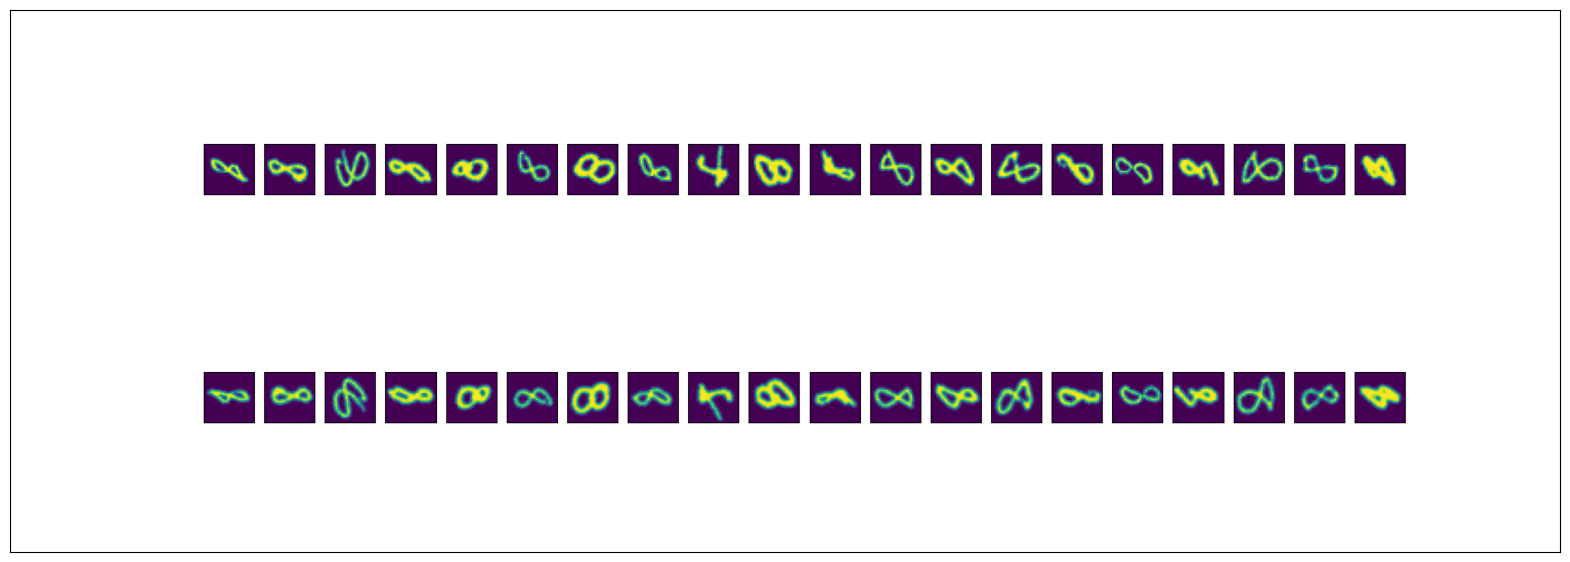

In [13]:
import matplotlib as mpl
# Visualize the canonical representation
os.makedirs(f"./plots/{EXPERIMENT}_IE-AE_COMPARISON", exist_ok=True)
sample_size = 20
mpl.rcParams.update(mpl.rcParamsDefault)

# Visualize for each class
sample_size = 20

# Visualize the canonical representations. 
delta = 15 # exploration margin (in degrees)

# Digits that have more than one canonical representation in the IE-AE can be found by exploring the "valleys" and anomalies in their psi density,
#  as these valleys can only occur when different canonical representations have been taken
if EXPERIMENT == "ROTMNIST60-90":
    location_canonicals = {
        4: {-100., 140.},  # location of different canonicals or "centers". They can be inferred from the psi density plot
        5: {-150., 100.},
        8: {-100., 150.},
        
    }
if EXPERIMENT == "MNISTMULTIPLE":
    location_canonicals = {
        5: {-75., 120.},  # location of different canonicals or "centers". They can be inferred from the psi density plot
        8: {100., -25.}   
    }


for target_digit in location_canonicals.keys():
    canons_list = location_canonicals[target_digit]
    for i_canon, location_canon in enumerate(canons_list): 
        break_loop = False
        count = 0
    
        fig_2, ax_2 = plt.subplots(nrows=2, ncols=sample_size, figsize=(20, 7))
    
        for x, label in test_dataloader:
            if break_loop:
                break
            x = x.cuda()
            label = label.long().cuda()
    
            with torch.no_grad():
                # Encoder pass
                emb, v = net.encoder(x)
                rot = net.get_rotation_matrix(v)
                degrees_rot = net.get_degrees(rot)
    
                # Canonical and recon pass
                canonical_rep = net.decoder(emb)
                recon = net.rot_img(canonical_rep, rot)
    
                # Standarized versions
                oriented = net.rot_img(x, rot, rot_inverse=True)
    
            # Plot digits
            for j in range(x.shape[0]):
                if int(label[j].item()) == target_digit:
                     if (degrees_rot[j] < location_canon + delta) and (degrees_rot[j] > location_canon - delta):   
        
                        ax_2[0, count].imshow(x[j].cpu().permute(1,2,0).squeeze())
                        ax_2[0, count].set_xticks([])
                        ax_2[0, count].set_yticks([])
                        img_or = oriented[j].detach().permute(1,2,0).cpu().squeeze()
                        ax_2[1, count].imshow(img_or)
                        ax_2[1, count].set_xticks([])
                        ax_2[1, count].set_yticks([])
        
                        count += 1
    
                        if count == sample_size:
                            fig_2.savefig(f"plots/{EXPERIMENT}_IE-AE_COMPARISON/Class_{str(target_digit)}_Center_{i_canon}_" + "Standardized.png")
                            #plt.show()
                            plt.close(fig_2)
                            break_loop = True
                            break

# Plot saved figures
plot_classes = list(location_canonicals.keys())
# Read the image from file
for target_digit in plot_classes:
    for i_canon in [0,1]:
        image_path = f"plots/{EXPERIMENT}_IE-AE_COMPARISON/Class_{str(target_digit)}_Center_{i_canon}_" + "Standardized.png"
        saved_image = mpimg.imread(image_path)
        
        fig, ax = plt.subplots(figsize=(20, 70))
        ax.imshow(saved_image)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.show()